# Capítulo 3. Experimentos Estatísticos e Teste de Significância

## 3.0 Imports

Import required Python packages.

In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import wquantiles
import random
import pingouin as pg

import matplotlib.pylab as plt
import matplotlib
from matplotlib import gridspec

import scipy
from scipy.stats import trim_mean
from scipy import stats
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power
from statsmodels import robust
from sklearn.utils import resample

from IPython.display import Image
from IPython.core.display import HTML


In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [3]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

### 0.1 Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [30, 15]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [5]:
jupyter_settings()

In [6]:
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('axes' ,labelsize=18)

## 3.1 Experimentos Estatísticos

O projeto de experimentos é um dos pilares da prática estatística, com aplicações em praticamente todas as áreas de pesquisa. 

**O objetivo é projetar um experimento a fim de confirmar ou rejeitar uma hipótese.**

<font color = red>**Os cientistas de dados são confrontados com a necessidade de conduzir experimentos contínuos, especialmente no que diz respeito à interface de usuário e marketing de produto.**</font>

Este capítulo revisa desenhos experimentais tradicionais e discute alguns desafios comuns na ciência de dados. 

Cobre também alguns conceitos comumente citados em inferência estatística e explica seu significado e relevância (ou falta de relevância) para a ciência de dados.

Sempre que você vir referências à **significância estatística**, testes t ou valores p, será tipicamente no contexto da **“cadeia” clássica** de inferência estatística (veja a Figura 3-1).

**O termo inferência reflete a intenção de aplicar os resultados do experimento, o que envolve um conjunto limitado de dados, em um processo ou população maiores.**

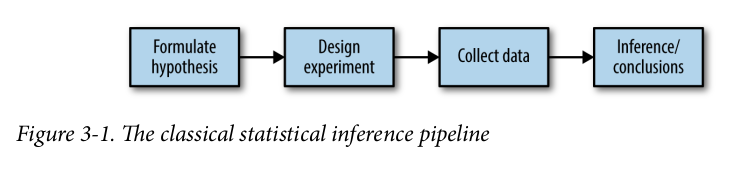

In [7]:
Image( '/home/deivison/Documentos/projetos/stats/imagem/cap_03_intro_1.png')

## 3.2 Teste A/B

### Termos Chaves

**Tratamento**
* Algo (droga, preço, título de site) ao qual um indivíduo é exposto.

**Grupo de tratamento**
* Um grupo de indivíduos expostos a um tratamento específico.

**Grupo de controle**
* Um grupo de indivíduos expostos a nenhum tratamento (ou padrão).

**Randomização**
* O processo de atribuir aleatoriamente indivíduos a tratamentos.

**Indivíduos**
* Os itens (visitantes de um site, pacientes etc.) que são expostos aos tratamentos.

**Estatística de teste**
* A métrica usada para medir o efeito do tratamento.

### Introdução

<font color = blue>**Um teste A/B é um experimento com dois grupos para determinar qual dos dois tratamentos, produtos, procedimentos ou semelhantes é o superior.**</font>

Geralmente, um dos dois tratamentos é o tratamento-padrão existente, ou nenhum tratamento. 

Se um tratamento-padrão (ou nenhum) for usado, este será chamado de controle. 

**Uma hipótese típica é a de que o tratamento seja melhor que o controle.**

Os testes A/B são comuns em web design e marketing, já que os resultados são tão facilmente mensuráveis.

Alguns exemplos de testagem A/B incluem:
* Testagem de dois tratamentos de solo para determinar qual deles gera melhor germinação de sementes.
* Testagem de duas terapias para determinar qual delas é mais efetiva na supressão do câncer.
* Testagem de dois preços para determinar qual gera mais lucro líquido.
* Testagem de dois títulos de site para determinar qual gera mais cliques
* Testagem de dois anúncios online para determinar qual gera mais conversões.

Um teste A/B adequado tem **indivíduos** que podem ser atribuídos a um tratamento ou outro. 

* O indivíduo pode ser uma pessoa, uma semente, um visitante de site, e a chave é que o indivíduo seja exposto ao tratamento. 

* **O ideal é que os indivíduos sejam randomizados (atribuídos aleatoriamente) aos tratamentos.**

Dessa forma, sabe-se que **qualquer diferença** entre os grupos de tratamento é devido a um dos seguintes motivos:
* O efeito de diferentes tratamentos.
* O sorteio no qual os indivíduos são atribuídos a quais tratamentos (ou seja, a atribuição aleatória pode resultar a concentração de indivíduos com melhor desempenho em A ou B).

<font color = red>**É necessário também prestar atenção à estatística de teste ou métrica usada para comparar o grupo A ao grupo B.**</font> 

Talvez a métrica mais comum em ciências de dados seja uma variável binária: 
* Clicar ou não clicar
* Comprar ou não comprar
* Fraude ou não fraude e assim por diante. 

Esses resultados seriam resumidos em uma tabela de 2×2. 

A Tabela 3-1 é uma tabela de 2×2 para um teste de preços real.

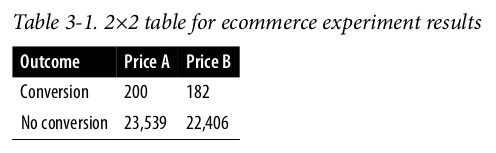

In [8]:
Image('/home/deivison/Documentos/projetos/stats/imagem/cap_03_intro_2.png')

Se a métrica for uma variável contínua (quantidade de compra, lucro etc.) ou uma contagem (por exemplo, dias em um hospital, páginas visitadas), o resultado pode ser exibido de modo diferente. 

Se o interesse não fosse a conversão, mas a receita por visualização de página, os resultados do teste de preço na Tabela 3-1 poderiam ficar assim em um resultado-padrão típico do software:
* Receita/visualização de página com preço A: média = 3.87, desvio_padrao = 51.10
* Receita/visualização de página com preço B: média = 4.11, desvio_padrao = 62.98

**O fato de os softwares estatísticos gerarem resultados por predefinição não significa que todos os resultados sejam úteis ou relevantes.** 

* Pode-se ver que os desvios-padrão anteriores não são tão úteis. 

* Por si só, sugerem que diversos valores podem ser negativos, quando a receita negativa não é viável. 

Esses dados são compostos de um pequeno conjunto de valores relativamente altos (visualizações de página com conversões) e um número enorme de valores 0 (visualizações de página sem conversão). 

É difícil resumir a variabilidade de tais dados com um único número, apesar de o desvio médio absoluto da média (7.68 para A e 8.15 para B) ser mais razoável do que o desvio-padrão.

### Por que ter um grupo de controle?

Por que não deixar de fazer o grupo de controle e apenas executar um experimento aplicando o tratamento de interesse em apenas um grupo e comparar o resultado com experiências anteriores? 

Sem um grupo de controle **não existem garantias** de que “outras coisas são iguais” e que quaisquer diferenças são realmente devidas ao tratamento (ou ao acaso). 

**Quando se tem um grupo de controle, este está sujeito às mesmas condições que o grupo de tratamento (exceto o tratamento de interesse).** 

Se é feita a simples comparação com uma “linha de base” ou uma experiência anterior, outros fatores, além do tratamento, podem ser diferentes.

O uso de testagem A/B em ciência de dados é comum em um contexto web. 

* Os tratamentos podem ser:
    * o design de uma página da web
    * o preço de um produto
    * a redação de um título ou algum outro item. 

* **É necessário haver uma certa reflexão a fim de preservar os princípios da randomização.**

* Geralmente, o indivíduo em um experimento é o visitante virtual, e os resultados em que estamos interessados em medir são:
    * cliques
    * compras
    * duração de visitas
    * número de páginas visitadas
    * onde uma página específica foi visitada e afins. 

<font color = blue>**Em um experimento A/B padrão, é necessário optar por uma métrica com antecedência.**</font>

* Múltiplas métricas podem ser coletadas e ser de interesse, mas se for esperado que o experimento leve a uma decisão entre o tratamento A e o tratamento B, deve-se estabelecer **uma única métrica, estatística de teste, com antecedência.** 

<font color = red>**Escolher uma estatística de teste após o experimento ser conduzido abre a porta para viés de pesquisador.**</font>



### Cegamento de Estudos

<font color = blue>**Um estudo cego é aquele em que os indivíduos não sabem se estão recebendo o tratamento A ou o tratamento B.**</font>

A consciência sobre a recepção de determinado tratamento pode afetar a resposta.

**Um estudo duplamente cego é aquele em que os investigadores e facilitadores (médicos e enfermeiras em um estudo médico) não sabem quais indivíduos estão recebendo qual tratamento.**

O cegamento não é possível quando a natureza do tratamento é transparente:
* Por exemplo, a terapia cognitiva de um computador versus um psicólogo.

### Por que apenas A/B? Por que não C,D...?

Os testes A/B são populares no mundo do marketing e do e-commerce, mas estão longe de ser o único tipo de experimento estatístico.

Podem ser incluídos tratamentos adicionais.

Os indivíduos podem ser medidos repetitivamente.

Estudos farmacêuticos, em que os indivíduos são escassos, caros e adquiridos ao longo do tempo, são muitas vezes desenhados com múltiplas oportunidades de parar o experimento e chegar a uma conclusão. 

**Designs tradicionais de estatística experimental se concentram em responder a uma pergunta estática sobre a eficácia de tratamentos específicos.**

Os cientistas de dados estão **menos** interessados na pergunta:

* A diferença entre o preço A e o preço B é estatisticamente significante?

Os cientistas de dados estão **mais** interessados na pergunta:

* Qual, entre múltiplos preços possíveis, é o melhor?

### Pedindo autorização

Em pesquisas científicas e médicas envolvendo indivíduos humanos, normalmente é necessário pedir sua permissão, bem como obter a aprovação de um conselho de revisão institucional.

Experimentos em negócios, que são feitos como parte de operações em andamento, quase nunca fazem isso. 

Na maioria dos casos (por exemplo, experimentos de precificação ou experimentos sobre qual título mostrar ou qual oferta deve ser feita), essa prática é muito aceita. 

No entanto, o Facebook foi contra essa aceitação geral em 2014, quando fez um experimento com o tom emocional no feed de notícias dos usuários. 

O Facebook usou análises de sentimento para classificar os posts do feed como positivos ou negativos, então alterou o equilíbrio positivo/negativo com o qual os exibia aos usuários. 

Alguns aleatoriamente selecionados recebiam mais posts positivos, enquanto outros recebiam mais posts negativos. 

O Facebook descobriu que os usuários que recebiam um feed mais positivo estavam mais propensos a fazer posts positivos e vice-versa. 

A magnitude do efeito foi pequena, no entanto, e o Facebook enfrentou muitas críticas por conduzir um experimento sem o conhecimento dos usuários. 

Alguns usuários especularam que o Facebook pode ter forçado a barra com alguns usuários extremamente depressivos, caso tenham recebido a versão negativa do feed.


## 3.3 Teste de Hipótese

### Termos Chaves

**Hipótese nula**
* A hipótese cuja possibilidade é provada.

**Hipótese alternativa**
* Contraponto da nula (o que se espera provar).

**Teste unilateral**
* Teste de hipótese que conta as possibilidades em apenas uma direção.

**Teste bilateral**
* Teste de hipótese que conta as possibilidades em duas direções.

### Introdução

<font color = blue>**Os testes de hipótese, também chamados de testes de significância, são onipresentes nas análises estatísticas tradicionais de pesquisas publicadas.**</font> 

**Seu propósito é ajudá-lo a descobrir se uma**</font> <font color = red>**chance aleatória**</font> **poderia ser responsável por um efeito observado.**

Um teste A/B costuma ser construído com uma hipótese em mente.

* Por exemplo, a hipótese pode ser a de que um preço B gera mais lucro. 
* Por que precisamos de uma hipótese?
* Por que não apenas observar o resultado do experimento e optar pelo tratamento que se sair melhor?
    * <font color = red>**A resposta está na tendência da mente humana de subestimar o escopo do comportamento aleatório natural.**</font> 

Uma manifestação disso é a falha em prever eventos extremos, também chamados de “cisnes negros”. 

Outra manifestação é a tendência de **interpretar** eventos aleatórios de **forma errada**, como se tivessem padrões de alguma significância. 

<font color = green>**A testagem de hipóteses estatísticas foi inventada como forma de proteger os pesquisadores de serem enganados pela possibilidade aleatória.**</font> 

Em um teste A/B bem projetado são coletados os dados sobre os tratamentos A e B, de modo que qualquer diferença observada entre A e B possa ser devido a um dos dois motivos a seguir:
* Possibilidade aleatória de atribuição de indivíduos.
* Uma diferença real entre A e B.

**Um teste de hipótese estatística é uma análise mais aprofundada de um teste A/B, ou qualquer experimento randomizado, para avaliar se a possibilidade aleatória é uma explicação plausível para a diferença observada entre os grupos A e B.**

### Interpretanto a Aleatoriedade de Forma Errada

<font color = red>**Pode-se observar a tendência humana a subestimar a aleatoriedade neste experimento.**</font>

Peça para diversos amigos inventarem uma série de 50 lançamentos de moeda: 
* Peça para escreverem uma série aleatória de caras e coroas.
* Então peça para realmente jogarem uma moeda 50 vezes e anotarem os resultados.
* Peça para colocarem os resultados reais dos lançamentos em uma pilha, e os resultados criados em outra.
* **É fácil adivinhar quais resultados são reais:**
    * Os reais terão séries mais longas de caras ou coroas.
    * Em um conjunto com 50 lançamentos de moeda reais, não é nada incomum encontrar cinco ou seis caras ou coroas seguidas. 
* No entanto, quando a maioria de nós está inventando lançamentos de moeda aleatórios, e colocamos três ou quatro caras seguidas, pensamos que, para que a série fique aleatória, seria melhor mudar para coroa.

**O outro lado desta moeda, por assim dizer, é que, quando vemos o equivalente real de seis caras seguidas, ficamos inclinados a atribuir isso a algo real, e não simplesmente ao acaso.**

### A Hipótese Nula

Os testes de hipótese utilizam a seguinte lógica:
* “Dada a tendência humana a reagir a comportamentos incomuns, mas aleatórios e interpretá-los como algo significativo e real, em nossos experimentos **vamos exigir provas de que a diferença entre os grupos** é mais extrema do que aquilo que a possibilidade poderia produzir aleatoriamente”.

<font color = blue>**Isso envolve uma SUPOSIÇÃO de linha de base de que os tratamentos são equivalentes, e qualquer diferença entre os grupos acontece devido ao acaso.**</font>

**Essa suposição de linha de base é chamada de hipótese nula.**

Nossa esperança é então poder, de fato, **provar que a hipótese nula está errada** e mostrar que os resultados para os grupos A e B são mais diferentes do que o acaso poderia produzir.

Um modo de fazer isso é através de um procedimento de reamostragem e permutação:
* Embaralhamos os resultados dos grupos A e B
* Distribuímos repetidamente os dados em grupos de tamanhos semelhantes
* Observamos com que frequência obtemos uma diferença tão extremaquanto a diferença observada.

### A Hipótese Alternativa

Os testes de hipótese envolvem, por natureza, não apenas uma hipótese nula, mas também uma hipótese alternativa contrária. 

Aqui estão alguns exemplos:
* Nula = “nenhuma diferença entre as médias dos grupos A e B”, alternativa = “A é diferente de B” (poderia ser maior ou menor)
* Nula = “A ≤ B”, alternativa = “B > A”
* Nula = “B não é X% maior que A”, alternativa = “B é X% maior que A”

<font color = red>**Em conjunto, as hipóteses nula e alternativa devem representar todas as possibilidades.**</font>

**A natureza da hipótese nula determina a estrutura do teste de hipótese.**

### Teste de Hipótese Unilateral e Bilateral

Geralmente, em um teste A/B se testa uma nova opção (digamos B), contra uma opção padrão estabelecida (A)

* A suposição de que se continuará com a opção padrão **a menos que** a nova opção se prove definitivamente melhor. 

* Nesse caso, é desejável haver um teste de hipótese para se proteger de ser enganado pelo acaso no favorecimento direcional.

Não importa ser enganado pelo acaso na outra direção, porque você permaneceria com A, a menos que B se prove definitivamente melhor.

Então é preciso haver uma hipótese alternativa direcional (B é melhor que A).

Nesse caso, se usa um teste de hipótese unilateral (ou unicaudal).
* Isso significa que a possibilidade extrema resulta apenas uma contagem de direção no sentido do valor p.

**Hipótese Bilateral**

Se você quer um teste de hipótese para se proteger de ser enganado pelo acaso em qualquer direção, a hipótese alternativa é bidirecional (A é diferente de B; poderia ser maior ou menor). 
* Nesse caso se usa uma hipótese bilateral (ou bicaudal). 
* Isso significa que possibilidades extremas resultam em contagens em qualquer uma das direções no sentido do valor p. 

Uma hipótese unicaudal costuma acomodar a natureza da tomada de decisão A/B, na qual uma decisão é necessária e uma opção costuma receber status “padrão”, a menos que a outra se prove melhor.

**Os softwares costumam oferecer o teste bicaudal em seus resultados predefinidos, e muitos estatísticos optam pelo teste bicaudal mais conservador apenas para evitar discussões.**

O assunto unicaudal versus bicaudal é confuso e sem muita relevância para a ciência de dados, em que a precisão dos cálculos de valor p não é extremamente importante.

## 3.4 Reamostragem

### Termos Chaves

**Testes de permutação**
* O procedimento de combinar duas ou mais amostras e aleatoriamente (ou exaustivamente) realocar as observações em reamostras.

**Sinônimos**
* teste de randomização, teste de permutação aleatória, teste exato

**Com ou sem reposição**
* Em amostragem, se um item será ou não recolocado na amostra antes da próxima extração.

### Introdução

<font color = red>**Reamostragem, em estatística, significa amostrar repetitivamente os valores a partir dos dados observados, com um objetivo geral de avaliar a variabilidade aleatória em uma estatística.**</font>

**Pode ser usada também para avaliar e aumentar a precisão de alguns modelos de aprendizado de máquina.**
* por exemplo, a média das previsões de modelos de árvores de decisão baseadas em múltiplos conjuntos de dados bootstrapped pode ser tirada em um processo conhecido como bagging

Existem dois tipos principais de procedimentos de reamostra: 

* O bootstrap 
    * O bootstrap é usado para avaliar a confiabilidade de uma estimativa;
* Os testes de permutação.
    * Testes de permutação são usados para testar hipóteses, geralmente envolvendo dois ou mais grupos

### Teste de Permutação

Em um procedimento de permutação são envolvidas duas ou mais amostras, geralmente os grupos em um teste A/B ou outros testes de hipótese.

Permuta significa mudar a ordem de um conjunto de valores.

O primeiro passo em um teste de permutação de uma hipótese é combinar os resultados dos grupos A e B (e, se usados, C, D…).

Essa é a representação lógica da hipótese nula da qual os tratamentos aos quais os grupos foram expostos não diferem.

Então testamos tal hipótese extraindo aleatoriamente os grupos desse conjunto combinado e vendo o quanto eles diferem um do outro. 

### Algoritmo do teste de permutação

O procedimento de permutação é o seguinte:
1. Combine os resultados dos diferentes grupos em um único conjunto de dados.
2. Embaralhe os dados combinados, então extraia aleatoriamente (sem reposição) uma reamostra de tamanho igual ao do grupo A.
3. Dos dados restantes, extraia aleatoriamente (sem reposição) uma reamostra de tamanho igual ao do grupo B.
4. Faça o mesmo para os grupos C, D e assim por diante.
5. Seja qual for a estatística ou estimativa calculada para as amostras originais: 
    * Por exemplo, diferenças entre proporções de grupo
    * Calcule-a agora para as reamostras e registre.
    * Isso constitui uma iteração de permutação.
6. Repita os passos anteriores R vezes para produzir uma distribuição de permutação da estatística de teste.

Agora volte à diferença observada entre os grupos e compare ao conjunto das diferenças permutadas.

Se a diferença observada estiver dentro do conjunto de diferenças permutadas
* Então não provamos nada
* A diferença observada está dentro do intervalo do que o acaso pode produzir.

No entanto, se a diferença observada estiver fora da maior parte da distribuição de permutação
* Então concluímos que o acaso não é responsável.
* Em termos técnicos, a diferença é estatisticamente significante.

### Exemplo Aderência Web

Uma empresa vendendo um serviço de **valor relativamente alto** quer testar qual entre duas páginas na web venderia mais.

Devido ao alto valor do serviço sendo vendido, as **vendas não são frequentes** e o ciclo de vendas é longo.

**Demoraria muito para acumular vendas suficientes para saber qual apresentação é superior.**

Então, a empresa decide medir os resultados com uma variável proxy, usando a página interna detalhada que descreve o serviço (página B).
* Uma potencial variável proxy para nossa empresa seria o número de cliques em uma página específica.
* <font color = blue>**Uma melhor seria quanto tempo as pessoas passam na página.**</font>

É importante pensar que uma página web (página B) que prenda a atenção das pessoas por mais tempo levará a mais vendas.

**Portanto, nossa métrica é o tempo médio de sessão, comparando a página A com a página B.**

Por ser uma página interior, especial, ela não recebe um grande número de visitantes.

Observe também que o Google Analytics, que é como medimos o tempo de sessão, não consegue medir o tempo de sessão para a última sessão que uma pessoa visita.

* Em vez de deletar aquela sessão dos dados, o GA a registra como um zero, então os dados exigem processamento adicional para remover aquelas sessões.

O resultado é um total de 36 sessões para as duas apresentações diferentes, 21 para a página A e 15 para a página B. 

In [9]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time
session_times

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0
5,Page B,85.0
6,Page A,211.0
7,Page B,246.0
8,Page A,132.0
9,Page B,149.0


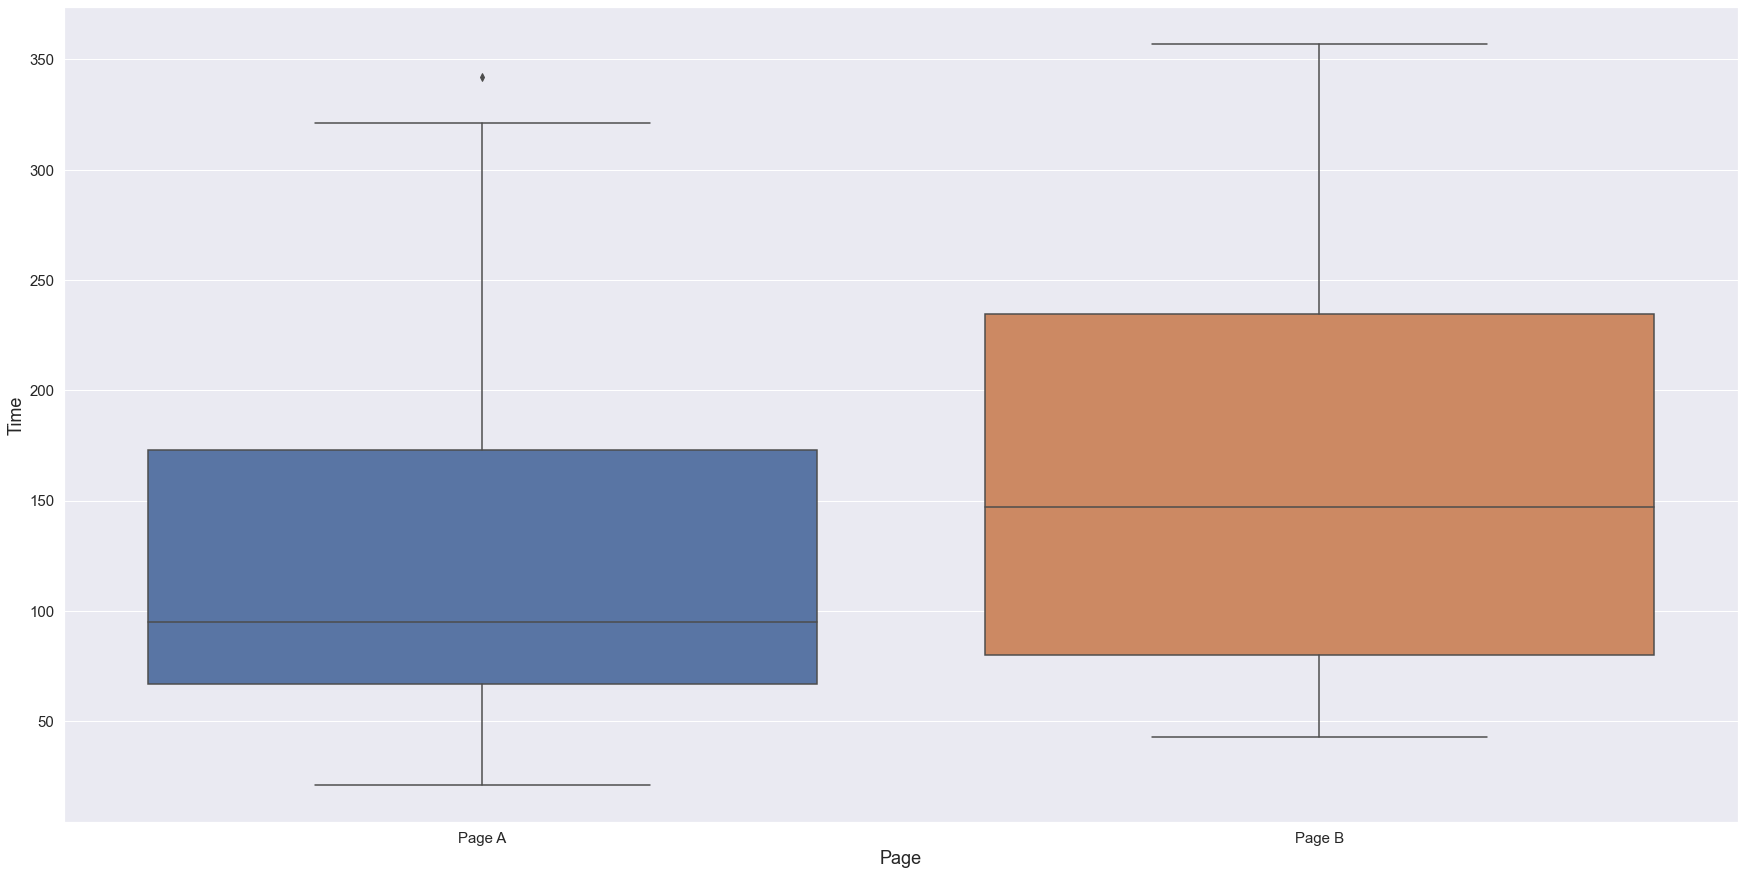

In [10]:
# Boxplot
sns.boxplot(data = session_times, x = 'Page', y = 'Time');

In [11]:
# media de cada pagina
aux1 = session_times[['Page','Time']].groupby('Page').mean().reset_index()
aux1

,Page,Time
0,Page A,126.333333
1,Page B,162.000000


In [12]:
# Diferenca entre as médias das paginas A e B
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


**A página B possui tempos de sessão 35.67 segundos maiores, em média, do que a página A.**

<font color = red>**A questão é se essa diferença está dentro da faixa do que o acaso poderia produzir ou, por outro lado, é estatisticamente significante.**</font> 

Um meio de responder isso é aplicando um teste de permutação
* Junte todos os tempos de sessão, então embaralhe repetidamente e divida em grupos de 21  e 15 
    * n = 21 para página A
    * n = 15 para página B

Para aplicar um teste de permutação, precisamos de uma função para atribuir aleatoriamente os 36 tempos de sessão a um grupo de 21 (página A) a um grupo de 15 (página B):

In [13]:
# Funcao Permutacao dos elementos da amostra
def perm_fun(x, nA, nB):
    #1. Combine os resultados dos diferentes grupos em um único conjunto de dados.
    n = nA + nB
    #2. Embaralhe os dados combinados, então extraia aleatoriamente (sem reposição) uma reamostra de tamanho igual ao do grupo B.
    idx_B = set(random.sample(range(n), nB))
    #3. Dos dados restantes, extraia aleatoriamente (sem reposição) uma reamostra de tamanho igual ao do grupo A.
    idx_A = set(range(n)) - idx_B
    #5. Seja qual for a estatística ou estimativa calculada para as amostras originais:
        # Por exemplo, diferenças entre as medias dos grupos
        # Calcule-a agora para as reamostras e registre.
        # Isso constitui uma iteração de permutação.
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

Essa função funciona reamostrando sem reposição n2 índices e atribuindo-os ao grupo B. 

Os índices n1 restantes são atribuídos ao grupo A. 

**A diferença entre as duas médias das reamostras é retornada.**

In [14]:
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print('\nNumero de elementos da reamostra A: {}'.format(nA))
print('\nNumero de elementos da reamostra B: {}'.format(nB))
print('\nTempo medio da reamostra B - tempo medio da reamostra A = {}'.format( perm_fun(session_times.Time, nA, nB)))
print('\nTempo medio da pagina B - tempo medio da pagina A = {}'.format(mean_b - mean_a))


Numero de elementos da reamostra A: 21

Numero de elementos da reamostra B: 15

Tempo medio da reamostra B - tempo medio da reamostra A = -21.933333333333337

Tempo medio da pagina B - tempo medio da pagina A = 35.66666666666667


**6. Repita os passos anteriores R vezes para produzir uma distribuição de permutação da estatística de teste.**

In [15]:
random.seed(1)
# R = 1000 vezes
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]
# 10 primeiras diferencas registradas das medias das paginas para cada reamostra/iteracao
perm_diffs[0:10]

[6.523809523809518,
 -17.59047619047618,
 22.866666666666674,
 -6.161904761904765,
 10.29523809523809,
 -9.019047619047626,
 5.838095238095235,
 -49.019047619047626,
 -7.6476190476190595,
 -14.733333333333348]

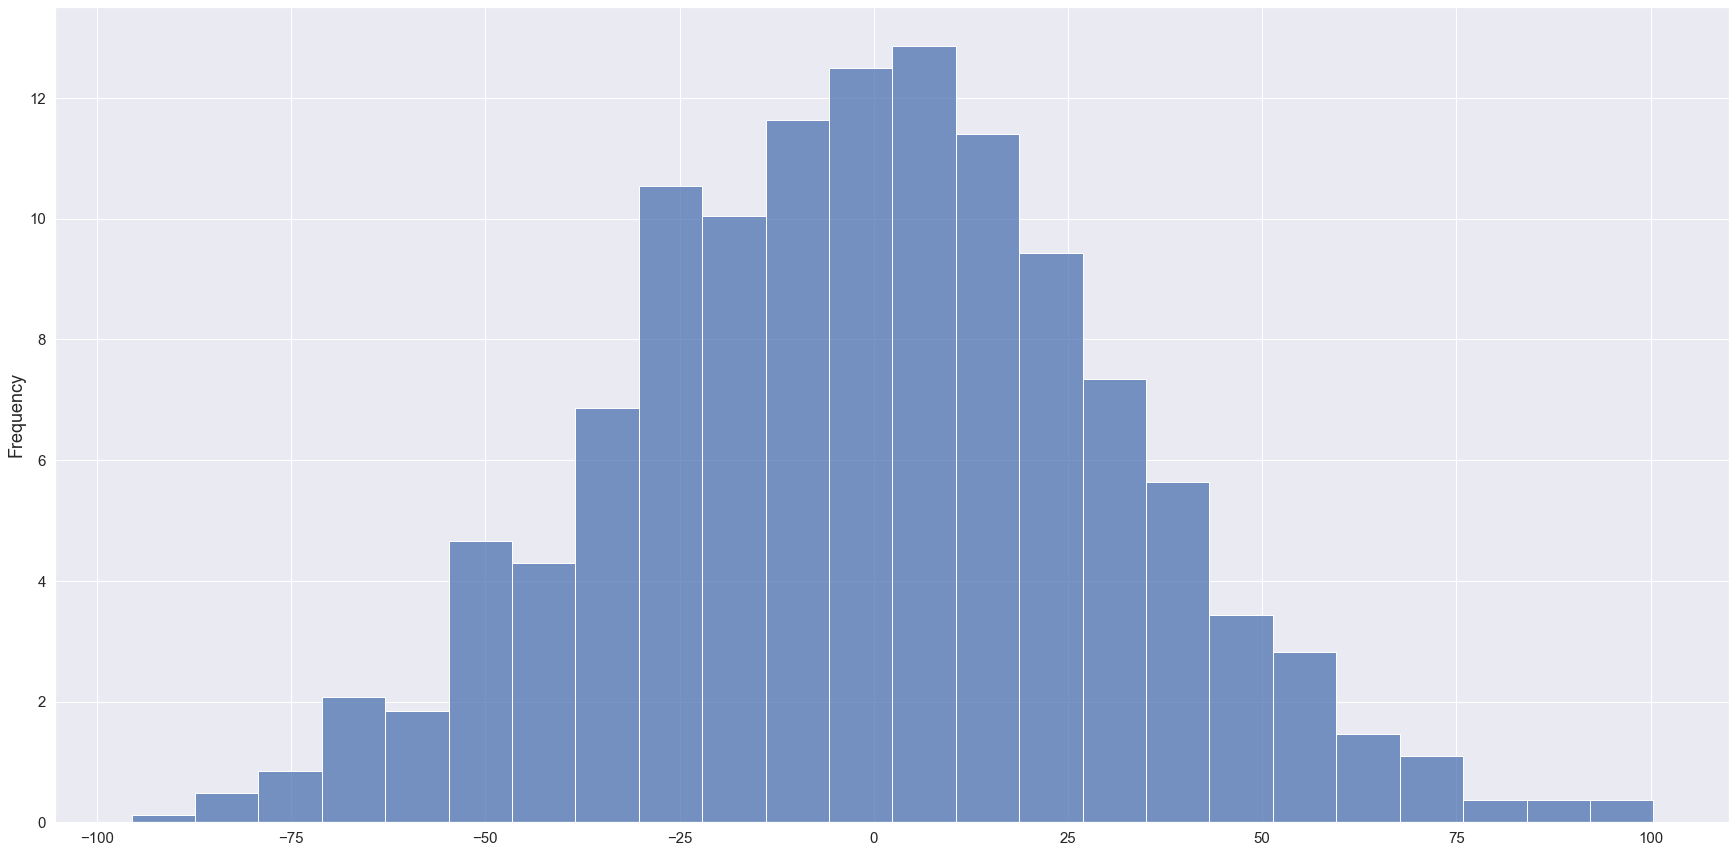

In [16]:
# histrograma da distribuição das diferenças entre as medias registradas de cada reamostra
sns.histplot(perm_diffs, stat = 'frequency');

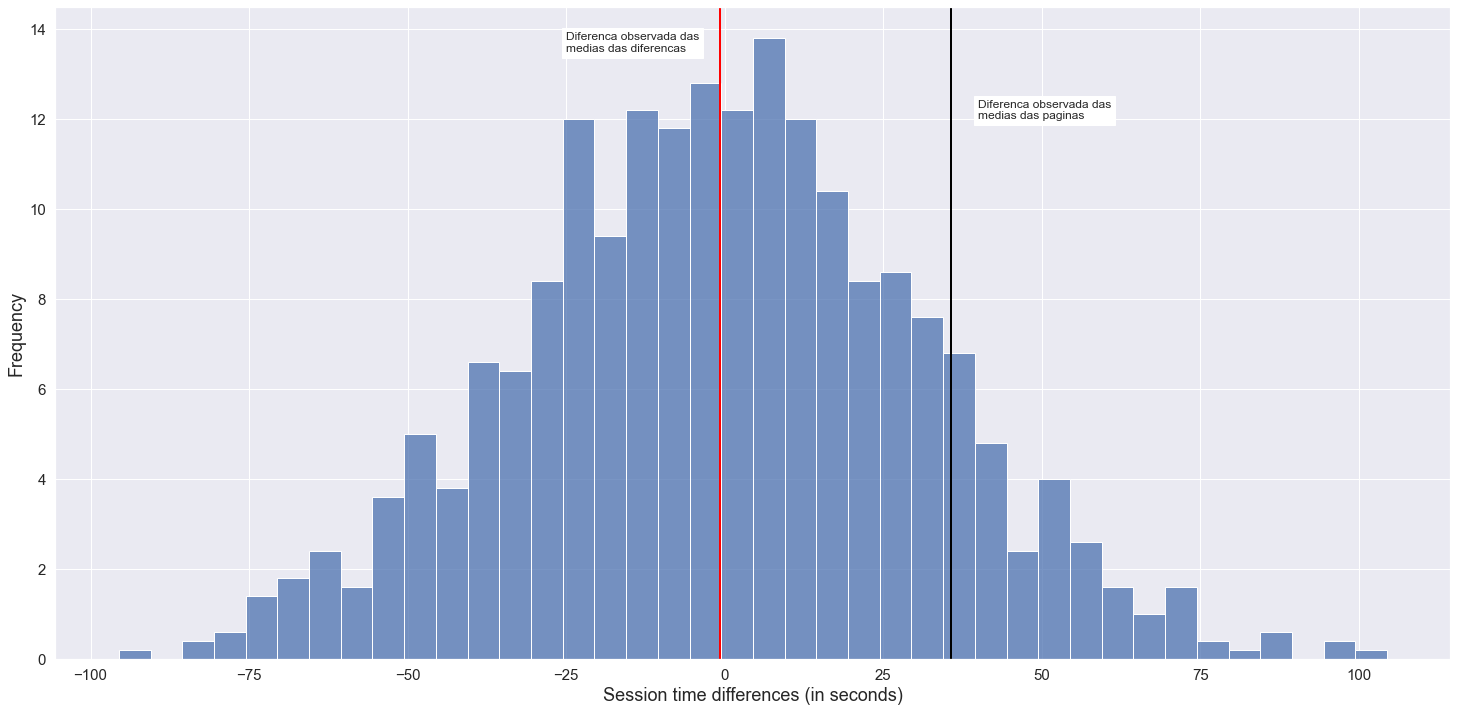

In [17]:
# histrograma da distribuição das diferenças entre as medias registradas de cada reamostra
fig, ax = plt.subplots(figsize=(25, 12))
sns.histplot(perm_diffs, stat = 'frequency', bins = 25, binwidth = 5, ax = ax);
ax.axvline(x = mean_b - mean_a, color='black', lw=2);
ax.axvline(x = np.mean(perm_diffs), color='red', lw=2);
ax.text(40, 12, 'Diferenca observada das\nmedias das paginas', bbox={'facecolor':'white'});
ax.text(-25, 13.5, 'Diferenca observada das\nmedias das diferencas', bbox={'facecolor':'white'});
ax.set_xlabel('Session time differences (in seconds)');
ax.set_ylabel('Frequency');
plt.show();

<font color = red>**Quantas vezes as diferenças entre as medias das reamostras foram maiores que 35,67 segundos (diferença entre as médias das páginas)?**</font>

In [18]:
print(np.mean(perm_diffs > mean_b - mean_a)*100,'%')

12.1 %


Isso sugere que a diferença observada no tempo de sessão entre a página A e a página B está dentro da faixa de variação de possibilidades, <font color = red>**então não é estatisticamente significante.**</font>

Ou seja, nesse experimento aleatório em 12,1% das vezes:
* A diferença entre as medias das paginas reamostradas foram maiores que 35,67 segundos.

**Tendo em vista a formulação do problema inicial da aderência Web**

<font color = green>**Então, a empresa decide medir os resultados com uma variável proxy, usando a página interna detalhada (página B) que descreve o serviço.**</font>
* <font color = blue>**variável proxy = quanto tempo as pessoas passam na página.**</font>
* É importante pensar que uma apresentação web (página B) que prenda a atenção das pessoas por **mais tempo levará a mais vendas.**
* **Portanto, nossa métrica é o tempo médio de sessão, comparando a página A com a página B.**

<font color = red>**Não podemos concluir com significancia estatistica que a diferença entre os tempos médios das paginas A e B levará a mais vendas da página B.**</font>

**A diferença observada de 35.67 segundos pode ter origem em causas aleatórias.**



### Testes de Permutação Exautiva e Bootstrap

Além do procedimento anterior de embaralhamento aleatório, também chamado de teste de permutação aleatória ou de teste de randomização, existem duas variações do teste de permutação
* Um teste de permutação exaustiva
* Um teste de permutação bootstrap

**Em um teste de permutação exaustiva:**
* Em vez de simplesmente embaralhar aleatoriamente e dividir os dados
* Na verdade adivinhamos todos os modos possíveis em que podem ser divididos.
    * Isso é prático apenas para tamanhos de amostra relativamente pequenos. 
* Com um número grande de embaralhamentos repetidos, os resultados do teste de permutação se aproximam daqueles do teste de permutação exaustiva e os abordam no limite.
* Os testes de permutação exaustiva também são chamados às vezes de testes exatos, devido à sua propriedade estatística de garantir que o modelo nulo não seja testado como “significante” além do nível alfa do teste.

**Em um teste de permutação bootstrap:**
* As extrações descritas nos passos 2 e 3 do teste de permutação aleatória são feitas com reposição, ao invés de sem reposição. 
* Dessa forma, o procedimento de reamostragem modela não somente o elemento aleatório na atribuição do tratamento ao indivíduo, mas também o elemento aleatório na seleção de indivíduos de uma população.
* Ambos os procedimentos são encontrados na estatística, e a distinção entre eles é um pouco complexa, e não consequência da prática da ciência de dados.

### Testes de Permutação: A Conclusão para a Ciência de Dados

Os testes de permutação **são úteis** em procedimentos heurísticos para a exploração do papel da variação aleatória.

<font color = red>**Eles são relativamente fáceis de codificar, interpretar e explicar e oferecem um desvio útil ao redor do formalismo e “falso determinismo” das estatísticas baseadas em fórmulas.**</font>

Uma virtude da reamostragem, ao contrário das abordagens por fórmula, **é que chega muito mais perto de uma abordagem “tamanho único” à inferência.**

Os dados podem ser numéricos ou binários.

Os tamanhos de amostra podem ser iguais ou diferentes.

<font color = blue>**As suposições sobre os dados normalmente distribuídos não são necessárias.**</font>

### Ideias Chaves

* Em um teste de permutação, múltiplas amostras são combinadas e então embaralhadas.
* Os valores embaralhados são então divididos em reamostras, e a estatística de interesse é calculada.
* Esse processo é então repetido, e a estatística reamostrada é tabulada.
* A comparação dos valores observados da estatística com a distribuição reamostrada permite julgar se uma diferença observada entre as amostras pode ocorrer por acaso.

## 3.5 Significância Estatística e Valores P

### Termos Chave

**Valor p**
* Dado um modelo de acaso que representa a hipótese nula, o valor p é a probabilidade de obter resultados tão incomuns ou extremos quanto os resultados observados.

**Alfa**
* Um limiar de probabilidade de “ser incomum” que os resultados do acaso podem ultrapassar, para resultados reais serem definidos como estatisticamente significantes.

**Erro tipo 1**
* Concluir erroneamente que um efeito é real (quando acontece pelo acaso).

**Erro tipo 2**
* Concluir erroneamente que um efeito ocorreu pelo acaso (quando é real).

### Introdução

**Significância estatística é como os estatísticos medem se um experimento (ou até mesmo um estudo de dados existente) produz um resultado mais extremo do que o acaso poderia produzir.**

Se o resultado estiver além do domínio da variação do acaso, é chamado de estatisticamente significante.

### Exemplo E-Commerce

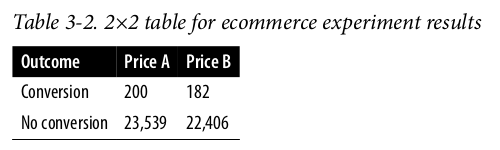

In [19]:
Image("/home/deivison/Documentos/projetos/stats/imagem/cap_03_ecommerce_1.png")

O preço A converte quase 5% melhor que o preço B
* (0.8425% = 200/(23539+200)* 100 versus 0.8057% = 182/(22406+182) * 100% 
* **Uma diferença de 0,0368 pontos percentuais**

A diferença é grande o bastante para ser significativo em um negócio de alto volume.
* Temos mais de 45 mil pontos de dados aqui
* é tentador considerar isso como “big data”, sem exigir testes de significância estatística.
    * necessários principalmente para contabilizar variabilidade amostral em pequenas amostras.

No entanto, as taxas de conversão são tão baixas (menos de 1%), que os valores realmente significativos — as conversões — estão apenas em centenas, e o **tamanho de amostra necessário é na verdade determinado por essas conversões.**

Podemos testar se a diferença das conversões entre os preços A e B está dentro da taxa de variação do acaso usando um procedimento de reamostragem. 

Por “variação do acaso” nos referimos à variação aleatória produzida por um modelo de probabilidade que representa a **hipótese nula de que não há diferença entre as taxas** 

O procedimento de permutação a seguir pergunta: 

<font color = red>**“Se os dois preços compartilham a mesma taxa de conversão, a variação do acaso poderia produzir uma diferença de 5%?”**</font>

**Teste de Permutação**

1. Crie uma urna com todos os resultados amostrais.
    * Isso representa a suposta taxa de conversão compartilhada de 382 uns e 45.945 zeros = 0,008246 = 0,8246%.
2. Embaralhe e extraia uma reamostra de tamanho 23.739 (mesmo n que o preço A), e registre a quantidade de 1s.
3. Registre o número de 1s nos 22.588 (mesmo n que o preço B) restantes.
4. Registre a diferença em proporção de 1s.
5. Repita os passos de 2 a 4.
6. Quão frequente foi a diferença >= 0.0368?


In [20]:
random.seed(1)
#diferenca percentual observada
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588) 
print(f'Observed difference: {obs_pct_diff:.4f}%')

conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)
print('\n Numero de conversoes da urna: {}'.format(conversion.loc[conversion==1].shape[0]))
print('\n Numero de zeros da urna: {}'.format(conversion.loc[conversion==0].shape[0]))

Observed difference: 0.0368%

 Numero de conversoes da urna: 382

 Numero de zeros da urna: 45945


In [21]:
random.seed(1)
# Calcular as diferenças entre as porcentagens para 1000 reamostras
perm_diffs = [100 * perm_fun(conversion, 23739, 22588) for _ in range(1000)]
# 10 primeiras diferenças entre as conversões dos precos
perm_diffs[0:10]

[-0.06267673224219054,
 -0.019478698206194106,
 0.023719335829802332,
 0.17923225835938977,
 -0.02811830501339343,
 -0.22682926157897723,
 -0.06267673224219054,
 -0.0453975186277919,
 -0.12315397989258554,
 0.023719335829802332]

In [22]:
df_perm_diffs = pd.DataFrame( perm_diffs, columns = ['diferenca'])
media = df_perm_diffs.mean().astype(float)
df_perm_diffs.head()

,diferenca
0,-0.062677
1,-0.019479
2,0.023719
3,0.179232
4,-0.028118


In [23]:
media

diferenca   -0.000947
dtype: float64

Text(0, 0.5, 'Frequency')

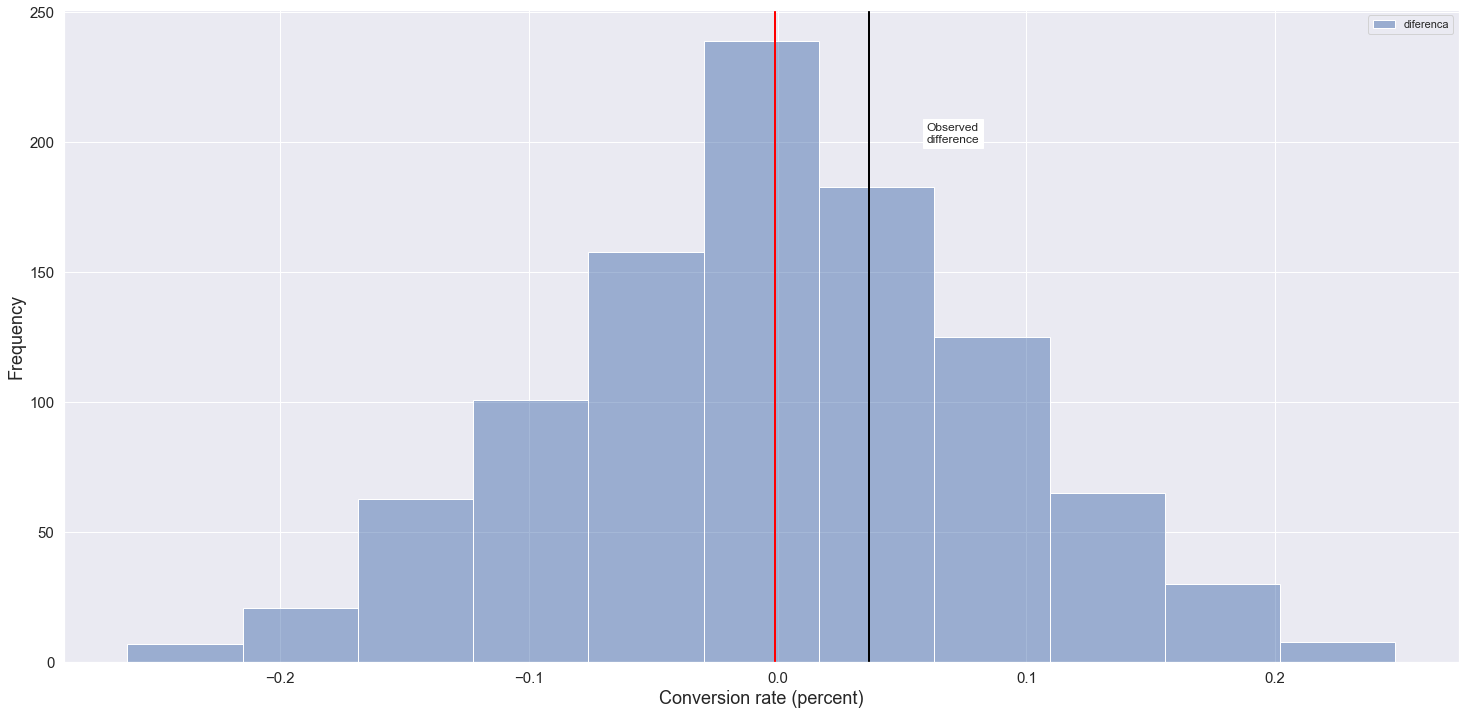

In [24]:
fig, ax = plt.subplots(figsize=(25, 12))
sns.histplot(data = df_perm_diffs, stat = 'count', bins = 11, ax = ax);
ax.axvline(x=obs_pct_diff, color='black', lw=2) #coloca a linha vertical no valor do percentual da diferenca
ax.axvline(x = media[0], color='red', lw=2) #coloca a linha vertical no valor medio do percentual da diferenca
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

In [25]:
# Diferencas maiores que 0,0368 %
df_perm_diffs.loc[(df_perm_diffs['diferenca'] > obs_pct_diff)].shape[0]

332

Veja o histograma de 1.000 resultados reamostrados:
* Conforme acontece, neste caso a diferença observada de 0,0368% está dentro da taxa de variação do acaso.

**Em 332 vezes das 1000 reamostras, observou-se que a diferenca entre os preços foram maiores que 0,0368%**

## 3.6 Valor P

<font color = blue>**A simples observação do gráfico não é um meio muito preciso de medir a significância estatística.**</font>

**Então o valor p é mais interessante.**

* Esta é a frequência com a qual o modelo de acaso produz um resultado mais extremo que o resultado observado. 
* Podemos estimar o valor p através de nosso teste de permutação tirando a proporção de vezes em que o teste de permutação produz uma diferença igual ou maior que a diferença observada:

O valor p é de 0.308, o que significa que podemos esperar atingir um resultado tão extremo quanto esse, ou mais extremo, através do acaso mais de 30% das vezes.

Neste caso, não precisamos um teste de permutação para obter um valor p.

Como temos uma distribuição binomial, podemos aproximar o valor p usando a distribuição normal.

In [26]:
# Em média as diferencas maiores correspondem
df_perm_diffs.loc[(df_perm_diffs['diferenca'] > obs_pct_diff)].shape[0] / df_perm_diffs.shape[0]

0.332

O método scipy.stats.chi2_contingency pega os valores mostrados na tabela do problema

In [27]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


**A aproximação normal produz um valor p de 0,3498, que é próximo ao valor p obtido no teste de permutação 0,332.**

### Alfa - Nível de Significância

<font color = blue>**Os estatísticos não gostam da ideia de deixar a definição de um resultado como “muito incomum” para acontecer por acaso a critério dos pesquisadores.**</font>

**Em vez disso, especifica-se com antecedência um limiar, como em “mais extremo que 5% do resultado do acaso rejeito a hipótese nula”.**

Esse limiar é conhecido como alfa.
* Quantos % de acaso eu tolero na minha análise?
* Os típicos níveis de alfa são 5% e 1%. 

Qualquer nível escolhido é uma escolha arbitrária
* Não há nada no processo que garante decisões corretas x% do tempo.

**Isso acontece porque a questão de probabilidade sendo respondida não é “qual é a probabilidade de isso ter acontecido por acaso?”**

<font color = red>**Mas, sim, “dado um modelo de acaso, qual é a probabilidade de haver um resultado tão extremo?”.**</font>

Nós então **deduzimos retroativamente** sobre a adequação do modelo de acaso, mas esse julgamento não traz uma probabilidade. 

Esse ponto tem sido assunto de muita confusão.

### O valor do valor P

Tem havido muita controvérsia em torno do uso do valor p nos últimos anos.

Um periódico de psicologia chegou a “banir” o uso de valores p em artigos apresentados com a justificativa de que publicar decisões com base somente no valor p estava resultando na publicação de pesquisas fracas.

Muitos pesquisadores, com uma ideia muito vaga do que o valor p realmente significa, mergulham nos dados e entre diferentes hipóteses possíveis para teste até encontrarem uma combinação que resulte em um valor p significativo e, portanto, um artigo adequado para publicação.

O real problema é que as pessoas querem um significado além daquele que o valor p oferece.

<font color = red>**Aqui está o que queríamos que o valor p expressasse:**</font>
* A probabilidade de que o resultado ocorre pelo acaso. 
* Esperamos um valor baixo, para que possamos concluir que provamos algo.
* Era assim que muitos editores de periódicos estavam interpretando o valor p.

<font color = red>**Mas aqui está o que o valor p expressa realmente:**</font>

**A probabilidade de que, dado um modelo de acaso, podem ocorrer resultados tão extremos quanto os resultados observados.**

A diferença é sutil, mas real. 

<font color = red>**Um valor p significativo não leva você tão longe no caminho da “prova” quanto parece prometer.**</font>

O fundamento lógico para a conclusão “estatisticamente significante” é um tanto mais fraco quando se entende o significado real do valor p.

### Nota de Advertência da American Statistical Association

Em março de 2016, a American Statistical Association (Associação Estatística Americana), após muita deliberação interna, revelou a dimensão da falta de entendimento sobre os **valores p** quando publicou uma nota de advertência quanto a seu uso.

A declaração da ASA frisou os **seis princípios** para pesquisadores e editores de periódicos:
1. Os valores p podem indicar o quanto os dados são incompatíveis com um modelo estatístico específico.
2. Os valores p **não medem a probabilidade de a hipótese estudada ser verdade** ou a probabilidade de os dados terem sido produzidos apenas pelo acaso.
3. Conclusões científicas e decisões empresariais ou políticas **não devem se basear apenas** no fato de um valor p exceder um limiar específico.
4. A inferência adequada exige informações completas e transparência.
5. Um valor p, ou significância estatística, **não mede o tamanho de um efeito ou a importância de um resultado.**
6. Sozinho, um valor p não oferece uma boa medição das evidências no que diz respeito a um modelo ou hipótese.

### Erros Tipo I e Tipo II

Na aferição da significância estatística, é possível haver dois erros:

**Erro tipo 1**
* Se conclui erroneamente que um efeito é real, quando, na verdade, ocorre por acaso.

**Erro tipo 2**
* Se conclui erroneamente que um efeito não é real (ou seja, ocorre por acaso), quando, na verdade, é real.

Na verdade, um erro tipo 2 não é bem um erro, mas, sim, uma conclusão de que o tamanho da amostra é muito pequeno para detectar o efeito.

Quando um valor p fica aquém da significância estatística (por exemplo, excede 5%), o que estamos dizendo, na verdade, é “efeito não provado”.
* Pode ser que uma amostra maior resulte em um valor p menor.

A função básica dos testes de significância (também chamados de testes de hipótese) é a proteção contra os enganos pelo acaso, então são comumente estruturados de modo a minimizar os erros Tipo 1.

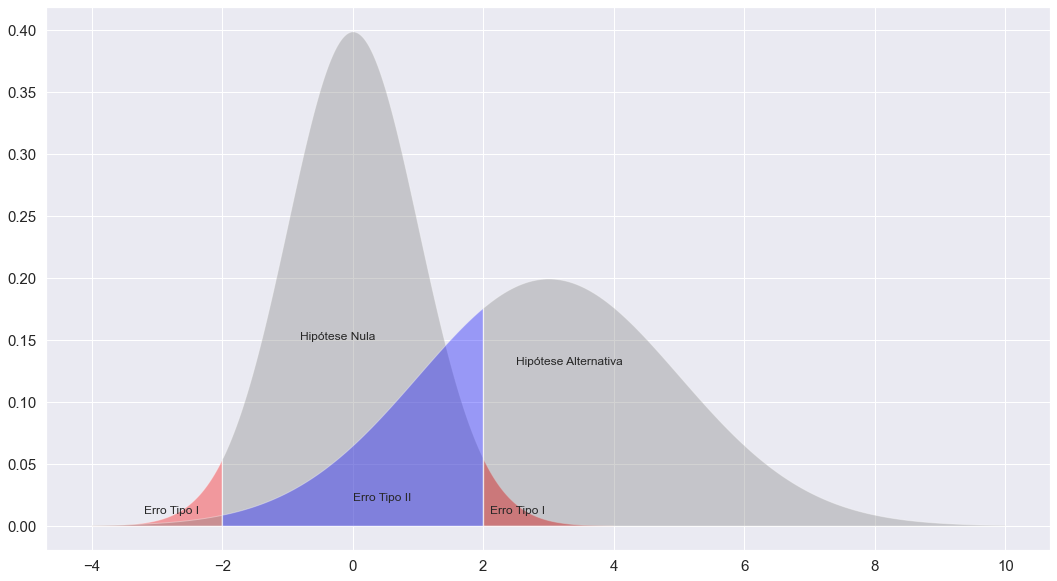

In [28]:
plt.figure( figsize = (18,10) )

plt.fill_between( x = np.arange(-4,-2,0.01 ), 
                  y1 = stats.norm.pdf( np.arange( -4,-2,0.01) ),
                  facecolor = 'red', alpha = 0.35 )

plt.fill_between( x = np.arange(-2,2,0.01 ), 
                  y1 = stats.norm.pdf( np.arange( -2,2,0.01) ),
                  facecolor = 'grey', alpha = 0.35 )

plt.fill_between( x = np.arange(2,4,0.01 ), 
                  y1 = stats.norm.pdf( np.arange( 2,4,0.01) ),
                  facecolor = 'red', alpha = 0.5 )

plt.fill_between( x = np.arange(-4,-2,0.01 ), 
                  y1 = stats.norm.pdf( np.arange( -4,-2,0.01), loc = 3, scale = 2 ),
                  facecolor = 'grey', alpha = 0.35 )

plt.fill_between( x = np.arange(-2,2,0.01 ), 
                  y1 = stats.norm.pdf( np.arange( -2,2,0.01), loc = 3, scale = 2  ),
                  facecolor = 'blue', alpha = 0.35 )

plt.fill_between( x = np.arange(2,10,0.01 ), 
                  y1 = stats.norm.pdf( np.arange( 2,10,0.01), loc = 3, scale = 2  ),
                  facecolor = 'grey', alpha = 0.35 )

plt.text( x= -0.8, y= 0.15, s = "Hipótese Nula");
plt.text( x=  2.5, y= 0.13, s = "Hipótese Alternativa");
plt.text( x=  2.1, y= 0.01, s = "Erro Tipo I");
plt.text( x= -3.2, y= 0.01, s = "Erro Tipo I");
plt.text( x= 0,    y= 0.02, s = "Erro Tipo II");

### Ciência de Dados e Valores P

O trabalho dos cientistas de dados não costuma se destinar a ser publicado em periódicos científicos, então o **debate sobre o valor do valor p é mais acadêmico.**

<font color = red>**Para um cientista de dados, um valor p é uma métrica útil em situações em que se quer saber se um resultado de modelo que parece interessante e útil está dentro da faixa de variabilidade de acaso normal.**</font>

Como uma ferramenta de tomada de decisão em um experimento, um valor p não deve ser considerado como dominante, mas meramente outro ponto de informação influenciando uma decisão.
* Por exemplo, os valores p às vezes são usados como entrada intermediária em um modelo estatístico ou de aprendizado de máquina
    * Uma variável/característica pode ser incluída ou excluída de um modelo dependendo de seu valor p.
    
**Ideias Chaves**
* Os testes de significância são usados para determinar se um efeito observado está dentro da faixa de variação do acaso para um modelo de hipótese nula.
* O valor p é a probabilidade de os resultados tão extremos quanto os resultados observados podem ocorrer, dado um modelo de hipótese nula.
* O valor alfa é o limiar de “não ser comum” em um modelo de acaso de hipótese nula.
* O teste de significância tem sido mais relevante para o registro formal de pesquisas do que para a ciência de dados.

## 3.7 Teste t

### Teoria

Existem inúmeros tipos de testes de significância, dependendo de os dados conterem dados contados ou dados medidos, quantas amostras existem e do que está sendo medido. 

Um tipo muito comum é o teste t, batizado assim por causa da distribuição t de Student, originalmente desenvolvida por W. S. Gossett para aproximar a distribuição de uma média amostral.

**Todos os testes de significância exigem que uma estatística de teste seja especificada para medir o efeito de interesse e ajudar a determinar se aquele efeito observado está dentro da taxa de variação normal do acaso.**

<font color = blue>**Em um teste de reamostragem, a escala dos dados não importa.**</font>

* **Você cria a distribuição de referência (hipótese nula) dos próprios dados e usa a estatística de teste como está.**

Nas décadas de 1920 e 1930, quando as testagens de hipóteses estatísticas estavam sendo desenvolvidas, não era viável embaralhar aleatoriamente os dados milhares de vezes para fazer um teste de reamostragem.

Os estatísticos descobriram que uma boa aproximação à distribuição de permutação (embaralhada) era o teste t, baseado na distribuição t de Gossett.

<font color = red>**O teste t é usado para uma comparação muito comum de duas amostras — teste A/B — nas quais os dados são numéricos.**</font>

Mas para que a distribuição t seja usada sem considerar a escala é preciso usar uma forma padronizada da estatística de teste.

Um texto estatístico clássico mostraria, neste ponto, diversas fórmulas que incorporam a distribuição de Gossett e demonstraria como padronizar seus dados para compará-los à distribuição t padrão.

A hipótese alternativa é a de que a média do tempo de sessão para a página A seja menor que a da página B.
* Isso é muito próximo do valor p de 0.124 do teste de permutação.

<font color = blue>**Em um modo de reamostragem, estruturamos a solução para refletir os dados observados e a hipótese a ser testada, sem nos preocupar se os dados são numéricos ou binários, se os tamanhos de amostra estão equilibrados ou não, com as variâncias das amostras ou diversos outros fatores.**</font>

No mundo das fórmulas, muitas variâncias se apresentam e podem ser confusas.

* Os estatísticos precisam navegar por esse mundo e conhecer seus mapas, mas os cientistas de dados não:
* Os cientistas de dados não costumam estar em posição de trabalhar os detalhes dos testes de hipótese e intervalos de confiança do mesmo modo que os pesquisadores que preparam artigos para apresentação.

### Teste t (Scipy e Statsmodels) - Exemplo Aderência Web

**SCIPY**

scipy.stats.ttest_ind(**a**, **b**, **axis**=0, **equal_var**=True, **nan_policy**='propagate', **permutations**=None, **random_state**=None, **alternative**='two-sided', **trim**=0)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html?highlight=stats%20ttest_ind#scipy.stats.ttest_ind

In [29]:
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


In [30]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False) #Se False, execute o teste t de Welch, que não assume variância populacional igual
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')
print(f't-statistic for single sided test: {res.statistic / 2:.4f}')

p-value for single sided test: 0.1408
t-statistic for single sided test: -0.5492


In [31]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False,  #Se False, execute o teste t de Welch, que não assume variância populacional igual
                      permutations = 1000,# número de permutações aleatórias que serão usadas para estimar valores-p usando um teste de permutação
                      random_state = 42) # Estado gerador de números pseudo-aleatórios usado para gerar permutações
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1415


**STATSMODELS**

statsmodels.stats.ttest_ind(**x1**, **x2**, **alternative**='two-sided', **usevar**='pooled', **weights**=(None, None), **value**=0)

https://www.statsmodels.org/devel/generated/statsmodels.stats.weightstats.ttest_ind.html?highlight=stats+ttest_ind#statsmodels.stats.weightstats.ttest_ind

In [32]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', # desigual, então Welch ttest com graus de liberdade Satterthwait é usado
    alternative='smaller') # A hipótese alternativa, H1, diferença nas médias menores que o valor
print(f'p-value: {pvalue:.4f}')
print(f't-statistic: {tstat:.4f}')
print(f'dof: {df:.4f}')

p-value: 0.1408
t-statistic: -1.0983
dof: 27.6934


A hipótese alternativa é que a média do tempo de sessão para a página A é menor do que para a página B.

O valor-p de 0,1408 é bastante próximo dos valores-p do teste de permutação de 0,121

## 3.8 Testagem Múltipla

### Termos Chaves

**Erro tipo 1**
* Concluir erroneamente que um efeito é estatisticamente significativo.

**Taxa de falsa descoberta**
* Através de múltiplos testes, a taxa de cometer um erro tipo 1.

**Ajuste dos valores p**
* Contabilização da realização de múltiplos testes nos mesmos dados.

**Sobreajuste**
* Ajuste do ruído.

### Teoria

Conforme mencionamos anteriormente, existe um ditado em estatística: 
* “Torture os dados o bastante, e eles vão confessar.” 

<font color = red>**Isso significa que se você observar os dados de diferentes perspectivas, e fizer perguntas o bastante, poderá, quase que invariavelmente, encontrar um efeito estatisticamente significativo.**</font>

* Por exemplo, se você tiver **20 variáveis preditoras e uma variável resposta**, todas aleatoriamente geradas, é bem provável que:
    * Ao menos um preditor será (falsamente) estatisticamente significativo se for feita uma série de 20 testes de significância em nível alfa = 0,05. 

    * **Conforme discutido anteriormente, isso é chamado de erro tipo 1.**

É possível calcular essa probabilidade encontrando primeiro a probabilidade de que todos serão testados corretamente não significativos no nível 0,05. 

* A probabilidade de que um será testado corretamente como não significativo é de 0,95
    * Então a probabilidade de que todos os 20 serão corretamente testados não significativos é de 0,95 × 0,95 × 0,95… ou ${0,95}²⁰$= 0,36. 

* A probabilidade de que ao menos um preditor seja (falsamente) testado significativo é o lado negativo dessa probabilidade, ou 1 
    * Probabilidade de todos serão não significantes = 0,64.

**Esse problema está relacionado ao problema de sobreajuste em pesquisa de dados, ou “ajustar o modelo ao ruído”.**

<font color = blue>**Quando mais variáveis forem adicionadas, ou mais modelos forem executados, maior é a probabilidade de algo se sobressair como “significativo” apenas por acaso.**</font>

Em tarefas de aprendizado supervisionado, um conjunto de retenção em que os modelos são avaliados em dados que o modelo não viu antes atenua esse risco. 

Em tarefas estatísticas ou de aprendizado de máquina que não envolvam um conjunto de retenção rotulado, o risco de chegar a conclusões baseadas em ruídos estatísticos permanece.

Em estatística existem alguns procedimentos destinados ao tratamento desse problema em circunstâncias muito específicas. 

Por exemplo, se estiver comparando resultados através de múltiplos grupos de tratamento, pode ser preciso fazer múltiplas perguntas. 

* Então, para tratamentos A–C, poderia perguntar:
    * A é diferente de B?
    * B é diferente de C?
    * A é diferente de C?

* Em um estudo clínico, pode ser necessário olhar os resultados de uma terapia em diversos estágios.
    * Em cada caso, serão feitas múltiplas perguntas, e com cada pergunta a chance de ser enganado pelo acaso será maior. 

Os procedimentos de ajuste em estatística podem compensar isso através de uma **definição mais rigorosa dos limites de significância estatística** do que seria para um único teste de hipótese. 

* Esses procedimentos de ajuste costumam envolver a “divisão de alfa” conforme o número de testes.

* Isso resulta em um alfa menor para cada teste.
    * Ou seja, um limite mais rigoroso para a significância estatística

    * Um desses procedimentos, **o ajuste de Bonferroni**, simplesmente divide o alfa pelo número de observações n.

No entanto, o problema de múltiplas comparações vai além desses casos altamente estruturados e está relacionado ao fenômeno de “dragagem” de dados repetidos, que dá força ao ditado sobre torturar os dados.

Colocando de outra forma, se você não encontrou nada interessante, provavelmente não procurou muito, nem por muito tempo. 

Hoje há mais dados disponíveis do que antigamente, e o número de artigos publicados em periódicos quase dobrou entre os anos de 2002 e 2010. 

Isso dá origem a muitas oportunidades de encontrar algo interessante nos dados, inclusive problemas de multiplicidade como:
* Verificar a existência de múltiplas diferenças de pares entre os grupos.
* Observar múltiplos resultados de subgrupos 
    * “não encontramos um efeito geral de tratamento significativo, mas encontramos um efeito para mulheres solteiras abaixo dos 30” 
* Tentar muitos modelos estatísticos
* Incluir muitas variáveis em modelos.
* Fazer inúmeras perguntas diferentes
    * Ou seja, diferentes resultados possíveis

<font color = blue>**Por diversas razões, incluindo especialmente esse problema geral de “multiplicidade”, pesquisar mais não significa necessariamente pesquisar melhor.**</font>

* Por exemplo, a companhia farmacêutica Bayer descobriu em 2011, quando tentou replicar 67 estudos científicos, que poderia replicar totalmente apenas 14 deles. 
* Quase dois terços não poderiam ser replicados de forma alguma.

**De qualquer modo, os procedimentos de ajuste para testes estatísticos altamente definidos e estruturados são muito específicos e inflexíveis para serem aplicados em usos gerais na ciência de dados.**

<font color = red>**A conclusão sobre multiplicidade para a ciência de dados é:**</font>
* Para modelagem preditiva, o risco de obter um modelo ilusório cuja eficácia aparente é mais um produto do acaso é mitigado pela validação cruzada e uso de uma amostra de retenção.
* Para outros procedimentos sem um conjunto de retenção rotulado para verificar o modelo, é necessário contar com:
    * A consciência de que quanto mais se questiona e manipula os dados, maior o papel que o acaso pode desempenhar.
    * A heurística da reamostragem e da simulação para referências aleatórias de acaso contra as quais se pode comparar os resultados observados.

### Taxa de Falsa Descoberta

O **termo** taxa de falsa descoberta foi originalmente usado para descrever a <font color = red>**taxa na qual um dado conjunto de testes de hipótese identificaria falsamente um efeito significativo.**</font> 

**Ela se tornou especialmente útil com o advento da pesquisa genômica**
* Em que números massivos de testes estatísticos podem ser conduzidos como parte de um projeto de sequenciamento genético. 

Nesses casos, o termo se aplica ao protocolo de testagem, e uma única “descoberta” falsa se refere ao resultado de um teste de hipótese
* por exemplo, entre duas amostras

Os pesquisadores procuram ajustar os parâmetros do processo de testagem a fim de controlar a taxa de falsa descoberta em um nível específico. 

**O termo também tem sido usado para classificação em mineração de dados:**
* é a taxa de classificação incorreta dentro das previsões de classe 1. 
* Ou, dito de outra forma, é a probabilidade de que uma “descoberta” (rotular um registro como “1”) seja falsa. 
* Aqui nós normalmente estamos lidando com o caso onde 0s são abundantes e 1s são interessantes e raros

### Ideias Chaves

* A multiplicidade em um estudo de pesquisa ou projeto de pesquisa de dados **aumenta o risco de concluir** que algo é significativo apenas pelo acaso.
    * Múltiplas comparações, muitas variáveis, muitos modelos etc
* Para situações envolvendo múltiplas comparações estatísticas, existem procedimentos de ajuste estatístico.
    * **ou seja, múltiplos testes de significância e muitos procedimentos de ajuste**
* Em uma situação de pesquisa de dados, o uso de uma amostra de retenção com variáveis de resultado rotuladas pode ajudar a evitar resultados enganosos.

## 3.9 Graus de Liberdade

### Termos Chave

**n ou tamanho da amostra**
* O número de observações (também chamadas de linhas ou registros) nos dados.

**g.l.**
* Graus de liberdade.

### Teoria

**O número de graus de liberdade é um fator em muitos testes estatísticos.**

Por exemplo, graus de liberdade é o nome dado ao denominador n – 1 visto nos cálculos de variância e desvio-padrão. 

**Por que isso importa?**

* Quando se usa uma amostra para estimar a variância de uma população, se usar n no denominador, obterá uma estimativa levemente enviesada para baixo. 
* Se usar n – 1 no denominador, a estimativa ficará livre desse viés.

Grande parte dos cursos ou livros tradicionais sobre estatística é consumida por diversos testes-padrão de hipóteses (teste t, teste F etc.). 

<font color = blue>**Quando as estatísticas amostrais são padronizadas para o uso em fórmulas estatísticas tradicionais:**</font>
* Os graus de liberdade fazem parte do cálculo de padronização
* **Garantem que os dados padronizados correspondam à distribuição de referências adequada**
    * Distribuição t, distribuição F, distribuição Normal, etc.

<font color = red>**É importante para a ciência de dados?**</font>

* **Não muito, ao menos no contexto de teste de significância.**

* Por um lado, os **testes estatísticos formais** são muito pouco usados na ciência de dados.

* Por outro, o tamanho dos dados costuma ser grande o bastante para raramente fazer diferença para um cientista de dados
    * se, por exemplo, o denominador tem n ou n – 1. 

<font color = red>**Porém, existe um contexto em que é relevante:**</font>
* O uso de variáveis fatoradas em regressão (inclusive regressão logística). 
* Os algoritmos de regressão travam se houver variáveis preditoras exatamente redundantes.
* Isso ocorre mais comumente ao fatorar variáveis categóricas em indicadores binários (dummies).

**Considere um dia da semana:**
* Apesar de haver sete dias da semana, existem **apenas seis graus de liberdade** ao especificar o dia da semana. 
* Por exemplo, uma vez que se sabe que o dia da semana não é de segunda a sábado, sabe-se que deve ser domingo. 
    * A inclusão de indicadores **seg-sáb** então significa que **incluir também o domingo causaria falha** na regressão, devido a um erro de **multicolinearidade.**

## 3.10 ANOVA

### Termos Chaves

**Comparação em pares**
* Um teste de hipótese (por exemplo, de médias) entre dois grupos em meio a múltiplos grupos.

**Teste coletivo**
* Um único teste de hipótese da variância geral entre múltiplas médias de grupo.

**Decomposição de variância**
* A separação de componentes, contribuindo com um valor individual (por exemplo, da média geral, de uma média de tratamento e de um erro residual).

**Estatística F**
* Uma estatística padronizada que mede o quanto as diferenças entre as médias dos grupos excedem o que poderia ser esperado em um modelo de acaso.

**SQ (SS)**
* A “Soma dos Quadrados (Sum of Squares)”, se referindo aos desvios de algum valor médio.

### Aderência Web - 4 Páginas

**A Tabela 3-3 mostra a aderência de quatro páginas web, em números de segundos gastos na página.**

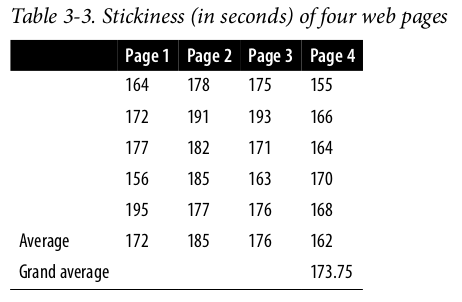

In [33]:
Image('/home/deivison/Documentos/projetos/stats/imagem/cap_03_anova_1.png')

<font color = red>**Situação de Negócio**</font>
* **As quatro páginas são trocadas aleatoriamente, de modo que um visitante receba uma aleatoriamente.**

* Existe um total de cinco visitantes em cada página
    * Na Tabela 3-3 cada coluna é um conjunto de dados independente.

* O primeiro visitante da página 1 não tem conexão com o primeiro visitante da página 2.

Observe que em um teste web como este não podemos implementar totalmente o projeto clássico de amostragem randomizada, em que cada visitante é selecionado aleatoriamente de uma grande população.

**Temos que obter os visitantes conforme chegam.**

* Os visitantes podem diferir sistematicamente dependendo:
    * da hora do dia
    * do dia da semana
    * da estação do ano
    * das condições de sua internet
    * de qual dispositivo estão usando e assim por diante.

* <font color = green>**Esses fatores devem ser considerados potenciais vieses quando os resultados do experimento forem revisados.**</font>


### Dataset do problema

In [34]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)
four_sessions

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172
5,Page 2,191
6,Page 3,193
7,Page 4,166
8,Page 1,177
9,Page 2,182


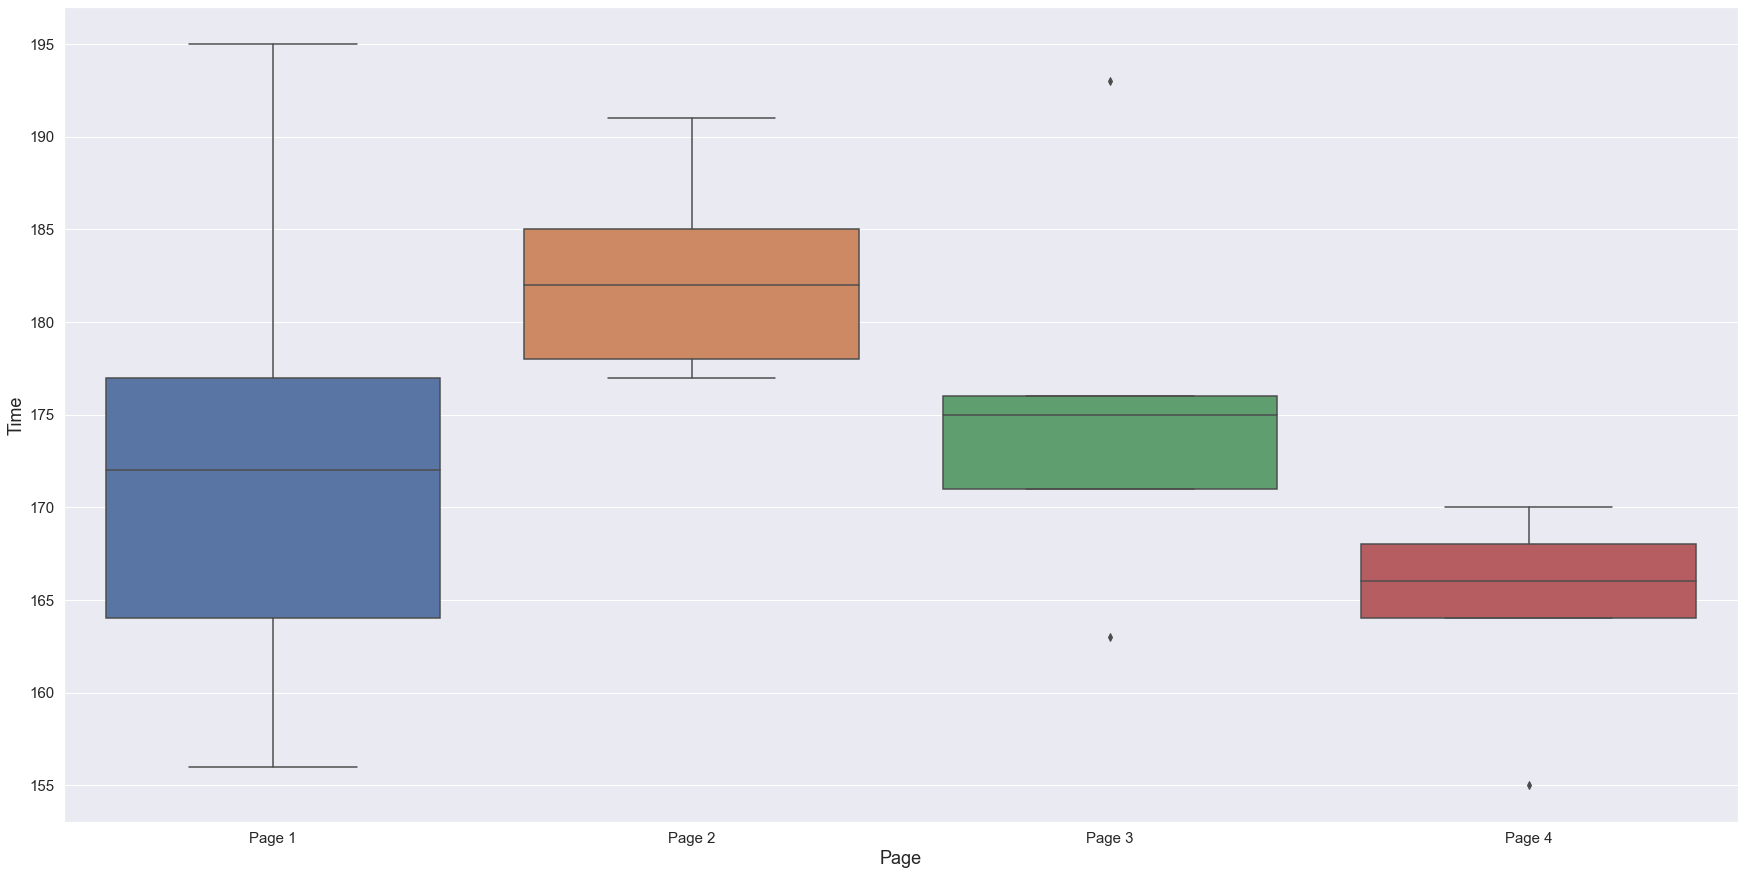

In [35]:
sns.boxplot(data = four_sessions, x = 'Page', y = 'Time');

Agora, temos um dilema. 

Quando estávamos comparando apenas dois grupos, era algo simples.

Simplesmente observávamos a diferença entre as médias de cada grupo.

Com quatro médias, existem seis possíveis comparações entre os grupos:
* Página 1 comparada à página 2.
* Página 1 comparada à página 3.
* Página 1 comparada à página 4.
* Página 2 comparada à página 3.
* Página 2 comparada à página 4.
* Página 3 comparada à página 4.

**Quanto mais fazemos tais comparações em pares, maior o potencial de sermos enganados pelo acaso**

Em vez de nos preocuparmos com todas as diferentes comparações entre as páginas individuais que poderíamos fazer, podemos fazer **um único teste coletivo** que aborda a questão: 

“Poderiam todas as páginas ter a mesma aderência subjacente, e as diferenças entre elas serem devido ao modo aleatório com que um conjunto comum de tempos de sessão foi alocado entre as quatro páginas?”

O procedimento usado para testar isso é a ANOVA.


### Algoritmo ANOVA

O procedimento ANOVA. 

A base disso pode ser vista no procedimento de reamostragem a seguir (especificado aqui para o teste A-B-C-D de aderência a páginas web):
1. Junte todos os dados em uma única caixa.
2. Embaralhe e tire quatro reamostras de cinco valores cada.
3. Registre a média de cada um dos quatro grupos.
4. Registre a variância entre as médias dos quatro grupos.
5. Repita os passos de 2 a 4 muitas vezes (digamos, mil vezes).

<font color = red>**Qual proporção do tempo a variância reamostrada excedeu a variância observada?**</font>

**Esse é o valor p.**

Esse tipo de teste de permutação é um pouco mais complicado que o tipo usado em “Teste de Permutação”, antes, neste capítulo.

In [36]:
# funcionamento da funcao de permutacao das variancias das medias
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    print(df,'\n')
    return df.groupby('Page').mean().var()[0]
    
print('Variancia das medias: {}'.format( perm_test(four_sessions)) )

      Page  Time
0   Page 1   172
1   Page 2   163
2   Page 3   177
3   Page 4   164
4   Page 1   171
5   Page 2   185
6   Page 3   191
7   Page 4   177
8   Page 1   193
9   Page 2   170
10  Page 3   156
11  Page 4   195
12  Page 1   182
13  Page 2   164
14  Page 3   176
15  Page 4   168
16  Page 1   178
17  Page 2   166
18  Page 3   175
19  Page 4   155 

Variancia das medias: 17.39999999999996


In [37]:
#calculo das medias de cada pagina
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())

# calculo da variancia das medias de cada pagina
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Variance:', observed_variance)

# Teste de permutacao
def perm_test(df):
    # 1. Junte todos os dados em uma única caixa.
    df = df.copy()
    # 2. Embaralhe e tire quatro reamostras de cinco valores cada.
    df['Time'] = np.random.permutation(df['Time'].values)
    # 3. Registre a média de cada um dos quatro grupos.
    # 4. Registre a variância entre as médias dos quatro grupos.
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))


Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
11.45333333333337


In [38]:
random.seed(1)
# 5. Repita os passos de 2 a 4 muitas vezes R = 3000 vezes
perm_variance = [perm_test(four_sessions) for _ in range(3000)]

# Proporção do tempo que a variância reamostrada excedeu a variância das medias das paginas
print('Proporcao Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

Proporcao Pr(Prob) 0.085


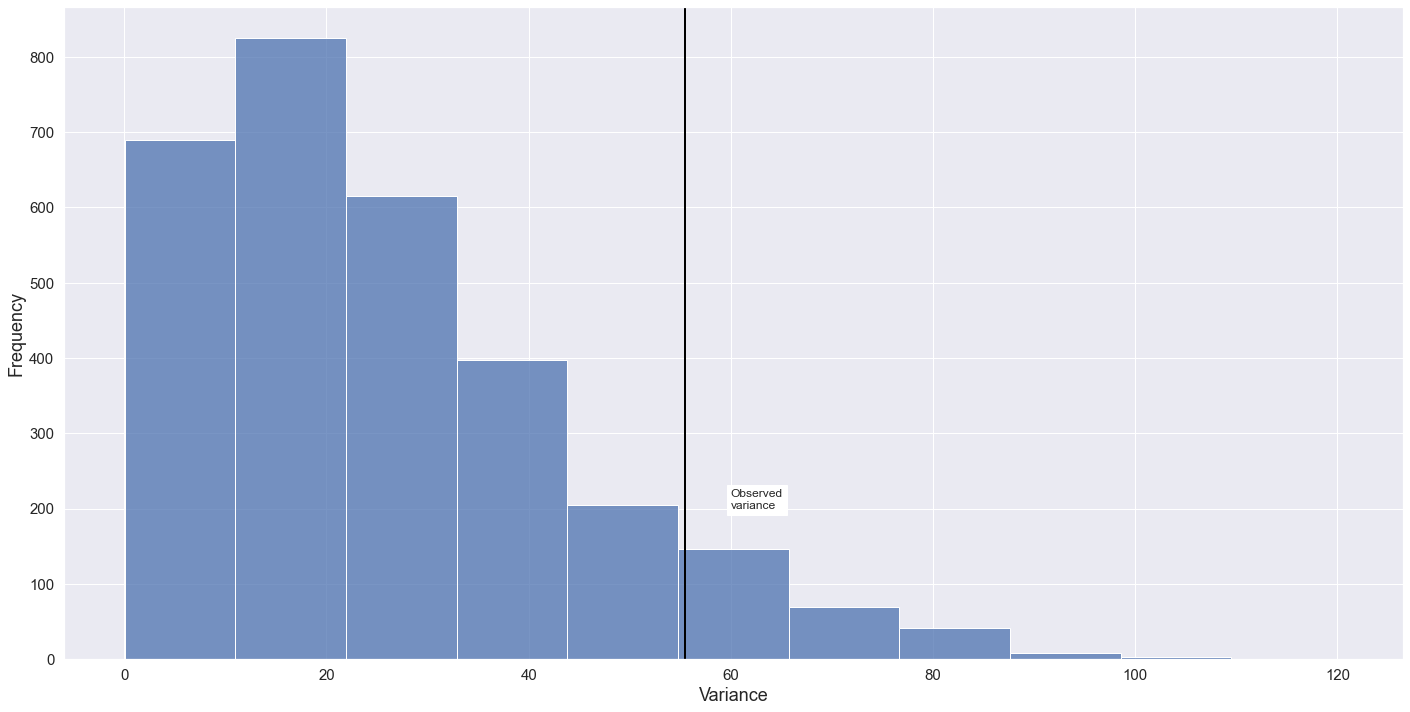

In [39]:
# histograma da variancias das 3000 permutacoes
fig, ax = plt.subplots(figsize=(24, 12))
sns.histplot(perm_variance, bins = 11, ax = ax);
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency');

<font color = red>**Qual proporção do tempo a variância reamostrada excedeu a variância
observada?**</font>

**Esse é o valor p.**

<font color = blue>**As variâncias das médias das 3000 reamostras foram maiores que a variância da média das paginas**</font>

**Em outras palavras, dada a mesma aderência subjacente, a taxa de resposta entre quatro páginas pode diferir tanto quanto foi realmente observado, apenas por acaso.**

<font color = red>**Esse grau de improbabilidade fica aquém do limite estatístico tradicional de 5%, então concluímos que a diferença entre as quatro páginas pode ter surgido por acaso.**</font>

## Estatística F

Assim como o teste t pode ser usado no lugar de um teste de permutação para comparar a média de dois grupos, existe um **teste estatístico para ANOVA baseado na estatística F.**

<font color = blue>**A estatística F se baseia na relação da variância entre as médias dos grupos com a variância devido a erro residual.**</font>
* variância, ou seja, o efeito do tratamento.
* Quanto maior essa relação, mais estatisticamente significativo é o resultado.

**Se os dados seguirem uma distribuição normal, então a teoria estatística determina que a estatística deve ter uma certa distribuição.**

* Com base nisso, é possível calcular:
    * Um valor p.
    * Df é “graus de liberdade 
        * Degrees of freedom
    * Sum Sq é “soma dos quadrados 
        * Sum of squares
    * Mean Sq é “quadrados médios”
        * Mean squares
        * Desvio quadrático médio
    * F value é a estatística F.
    

### Exemplo Aderência Web

**Calculo biblioteca STATSMODELS**

https://www.statsmodels.org/dev/generated/statsmodels.stats.anova.anova_lm.html

In [40]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


**Calculo biblioteca Pingouin**

https://pingouin-stats.org/generated/pingouin.anova.html#pingouin.anova

In [41]:
aov = pg.anova(dv='Time', between='Page', data=four_sessions,
               detailed=True)
aov.round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,Page,831.4,3,277.133,2.74,0.078,0.339
1,Within,1618.4,16,101.150,NaN,NaN,NaN


**Calculo biblioteca SCIPY**

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

In [42]:

res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


Para a média global:
* A soma dos quadrados é a partida da média global de 0 quadrático vezes 20 (o número de observações). 
* O grau de liberdade para a média global é 1, por definição.

Para as médias de tratamento:
* O grau deliberdade é 3 
* Uma vez que três valores estejam ajustados, e então a média global seja ajustada, as outras médias de tratamento não podem variar
* A soma dos quadrados para as médias de tratamento é a soma das partidas quadráticas entre as médias de tratamento e a média global.

Para os resíduos:
* O grau de liberdade é 20 (todas as observações podem variar)
* SS é a soma das diferenças quadráticas entre as observações individuais e as médias de tratamento.

As médias quadráticas (mean squares) (MS) são a soma dos quadrados divididas pelos graus de liberdade.

**A estatística F é MS(tratamento)/MS(erro).**

<font color = red>**O valor F depende, então, apenas dessa proporção, e pode ser comparado a uma distribuição F padrão para determinar se as diferenças entre as médias de tratamento são maiores do que o esperado em uma variação de acaso.**</font>

### Decomposição da Variância - Cálculo passo a passo

In [43]:
#Dataset
four_sessions

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172
5,Page 2,191
6,Page 3,193
7,Page 4,166
8,Page 1,177
9,Page 2,182


Os valores observados em um conjunto de dados podem ser considerados somas de diferentes componentes.

Qualquer valor de dado observado dentro de um conjunto de dados pode ser decomposto:
* na média global
* no efeito do tratamento
* no erro residual

Chamamos isso de uma “decomposição de variância”.
1. Comece com uma média global 
    * 173,75 para todos os 20 dados de aderência de página web
2. Adicione o efeito do tratamento, que pode ser negativo
    * variável independente = página web
3. Adicione o erro residual, que pode ser negativo.

Então a decomposição da variância para o valor superior esquerdo na tabela do teste A-B-C-D é a seguinte:
1. Comece com a média global: 173,75.
2. Adicione o efeito do tratamento (grupo): –1,75 (172 – 173,75).
3. Adicione o residual: –8 (164 – 172).
4. Igual a: 164.

In [44]:
aux2 = pd.DataFrame(columns=['usuario'])
aux2['usuario']=[1,2,3,4,5]

#1. Comece com uma média global
aux2['global_mean']=four_sessions['Time'].mean()

# pagina 1 
aux2['page_1']=list(four_sessions[four_sessions.Page == 'Page 1'].Time)
aux2['page_1_mean']=aux2['page_1'].mean()
# 2. Adicione o efeito do tratamento na pagina, que pode ser negativo
aux2['page_1_tratamento']=aux2['page_1_mean'] - aux2['global_mean']
# 3. Adicione o erro residual, que pode ser negativo.
aux2['page_1_erro']=aux2['page_1'] - aux2['page_1_mean']

# pagina 2
aux2['page_2']=list(four_sessions[four_sessions.Page == 'Page 2'].Time)
aux2['page_2_mean']=aux2['page_2'].mean()
# 2. Adicione o efeito do tratamento na pagina, que pode ser negativo
aux2['page_2_tratamento']=aux2['page_2_mean'] - aux2['global_mean']
# 3. Adicione o erro residual, que pode ser negativo.
aux2['page_2_erro']=aux2['page_2'] - aux2['page_2_mean']

# pagina 3
aux2['page_3']=list(four_sessions[four_sessions.Page == 'Page 3'].Time)
aux2['page_3_mean']=aux2['page_3'].mean()
# 2. Adicione o efeito do tratamento na pagina, que pode ser negativo
aux2['page_3_tratamento']=aux2['page_3_mean'] - aux2['global_mean']
# 3. Adicione o erro residual, que pode ser negativo.
aux2['page_3_erro']=aux2['page_3'] - aux2['page_3_mean']

# pagina 4
aux2['page_4']=list(four_sessions[four_sessions.Page == 'Page 4'].Time)
aux2['page_4_mean']=aux2['page_4'].mean()
# 2. Adicione o efeito do tratamento na pagina, que pode ser negativo
aux2['page_4_tratamento']=aux2['page_4_mean'] - aux2['global_mean']
# 3. Adicione o erro residual, que pode ser negativo.
aux2['page_4_erro']=aux2['page_4'] - aux2['page_4_mean']

aux2

,usuario,global_mean,page_1,page_1_mean,page_1_tratamento,page_1_erro,page_2,page_2_mean,page_2_tratamento,page_2_erro,page_3,page_3_mean,page_3_tratamento,page_3_erro,page_4,page_4_mean,page_4_tratamento,page_4_erro
0,1,173.9,164,172.8,-1.1,-8.8,178,182.6,8.7,-4.6,175,175.6,1.7,-0.6,155,164.6,-9.3,-9.6
1,2,173.9,172,172.8,-1.1,-0.8,191,182.6,8.7,8.4,193,175.6,1.7,17.4,166,164.6,-9.3,1.4
2,3,173.9,177,172.8,-1.1,4.2,182,182.6,8.7,-0.6,171,175.6,1.7,-4.6,164,164.6,-9.3,-0.6
3,4,173.9,156,172.8,-1.1,-16.8,185,182.6,8.7,2.4,163,175.6,1.7,-12.6,170,164.6,-9.3,5.4
4,5,173.9,195,172.8,-1.1,22.2,177,182.6,8.7,-5.6,176,175.6,1.7,0.4,168,164.6,-9.3,3.4


In [45]:
# Soma dos desvios quadraticos das variacoes dos tratamentos entre as paginas
    # tratamentos = medias de cada pagina
var_entre_paginas = (np.square(aux2['page_1_tratamento']).sum() +
                     np.square(aux2['page_2_tratamento']).sum() +
                     np.square(aux2['page_3_tratamento']).sum() +
                     np.square(aux2['page_4_tratamento']).sum() ) / (4-1)
var_entre_paginas

277.13333333333327

In [46]:
# Soma dos desvios quadraticos das variacoes dos erros dentro de cada pagina
var_dentro_da_pagina = (np.square(aux2['page_1_erro']).sum() +
                        np.square(aux2['page_2_erro']).sum() +
                        np.square(aux2['page_3_erro']).sum() +
                        np.square(aux2['page_4_erro']).sum() ) / (20-4)
var_dentro_da_pagina

101.15

In [47]:
F = var_entre_paginas / var_dentro_da_pagina
F

2.7398253419014655

### Anova Birecional

**O teste A-B-C-D descrito é uma ANOVA “unidirecional”, em que temos apenas um fator (grupo) que está variando.**

<font color = red>**Poderíamos ter um segundo fator envolvido**</font>
* Digamos, “fim de semana versus dia útil” 
* Com dados coletados em cada combinação (grupo A dia útil, grupo B fim de semana etc.).

Isso seria uma “ANOVA bidirecional”, e trataríamos isso de modo semelhante ao da ANOVA unidirecional, **identificando o “efeito de interação”.**

Depois de identificar o efeito da média global e o efeito do tratamento
* Separamos as observações de fim de semana e dia útil de cada grupo
* Encontramos a diferença entre as médias para aqueles subconjuntos e a média do tratamento.

Pode-se ver que a ANOVA e a ANOVA bidirecional são os primeiros passos no caminho em direção a um modelo estatístico completo:
* regressão
* regressão logística
* Em que se pode modelar múltiplos fatores e seus efeitos.

### Ideias Chave

* ANOVA é um procedimento estatístico para analisar os resultados de um experimento com múltiplos grupos.

* É a extensão de procedimentos semelhantes para o teste A/B, usado para avaliar se a variação global entre os grupos está dentro da taxa de variação do acaso.

* Um resultado útil de uma ANOVA é a identificação de componentes de variância associados com tratamentos de grupo, efeitos de interação e erros.

## 3.11 Test Qui Quadrado -  Chi-Square Test

### Termos Chaves

**Estatística qui quadrada**
* Uma medida da extensão em que alguns dados observados partem da expectativa.

**Expectativa ou esperado**
* Como esperamos que os dados se comportem sob alguma suposição, tipicamente a hipótese é nula.

**g.l.**
* Graus de liberdade.

### Introdução

A testagem web costuma ir além da testagem A/B e testa múltiplos tratamentos ao mesmo tempo.

<font color = red>**O teste de qui quadrado é usado para contar os dados para testar quão bem se encaixam em alguma distribuição desejada.**</font>

**O uso mais comum da estatística qui quadrada em prática estatística é:**
* Com tabelas de contingência r × c
    * r × c significa “linhas por colunas (rows by columns)”
    * uma tabela de 2×3 tem duas linhas e três colunas
* Para avaliar se a hipótese nula de independência entre as variáveis é razoável.

O termo “qui” vem da letra grega ξ usada por Pearson em 1900.

### Teste Qui Quadrado: Uma Abordagem à Reamostra

Suponha que está testando três títulos diferentes nas páginas web A, B e C
* Cada pagina recebe 1.000 visitantes, com os resultados mostrados na Tabele 3-4.

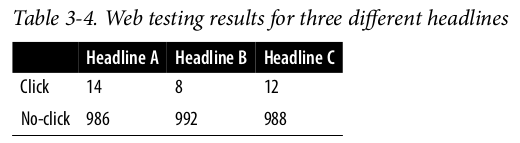

In [48]:
Image('/home/deivison/Documentos/projetos/stats/imagem/cap_03_chi_1.png')

In [49]:
# Table 3-4
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


Os títulos certamente parecem diferir.

* O título A retorna quase que o dobro de taxa de cliques que o B.

* Porém, os números reais são pequenos.

**Um procedimento de reamostragem pode testar se as taxas de clique diferem em níveis maiores do que o acaso poderia produzir.**

Para esse teste, precisamos ter a distribuição “esperada” de cliques:
* Neste caso, isso seria sobre a suposição de hipótese nula de que todos os três títulos apresentam a mesma taxa de cliques
* Para uma taxa global de cliques de 34/3.000. (14+8+12)/3000 visitantes
* Sob essa suposição, nossa tabela de contingência ficaria como a Tabela 3-5.

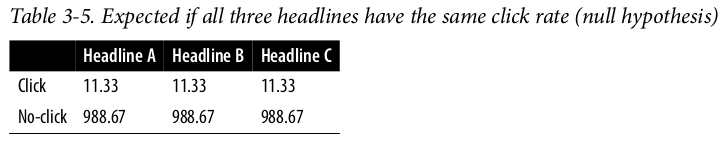

In [50]:
Image('/home/deivison/Documentos/projetos/stats/imagem/cap_03_chi_2.png')

In [51]:
# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


### Cálculo do Resíduo de Pearson

O residual de Pearson é definido como:

R = $\frac{Valor Observado - Valor Esperado}{\sqrt{Valor Esperado} }$

R mede a extensão em que as contagens realmente diferem dessas contagens esperadas.

In [52]:
# Calculo do resíduo para Headline A
r1 = (14-11.33)/np.sqrt(11.33)
r2 = (986-988.6667)/np.sqrt(988.6667)
print(r1)
print(r2)

0.7932248412147792
-0.08481041876478608


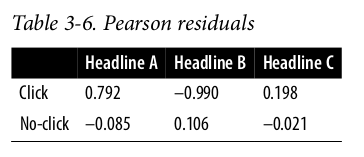

In [53]:
Image('/home/deivison/Documentos/projetos/stats/imagem/cap_03_chi_3.png')

A estatística qui quadrada é definida como a soma dos residuais quadráticos de Pearson.

$\sum \limits _{i} ^{Linha} \sum \limits _{j} ^{Coluna} R² $

em que Linha e Coluna são os números de linhas e colunas, respectivamente. 

A estatística qui quadrada para esse exemplo é 1.666.

Isso é mais do que poderia plausivelmente ocorrer em um modelo de acaso?

In [54]:
l1=np.square(0.792)+np.square(-0.990)+np.square(0.198)
l2=np.square(-0.085)+np.square(0.106)+np.square(-0.021)

In [55]:
l1+l2

1.66547

### Abordagem de reamostra

Podemos testar com esse algoritmo de reamostragem:
1. Forme uma caixa com 34 uns (cliques) e 2,966 zeros (sem cliques).
2. Embaralhe, tire três amostras separadas de 1.000 e conte os cliques em cada uma.
3. Encontre as diferenças quadráticas entre as contagens embaralhadas e as contagens esperadas e some.
4. Repita os passos 2 e 3, digamos, 1.000 vezes.
5. Com qual frequência a soma reamostrada dos desvios quadráticos excede a observada? Esse é o valor p.

In [56]:
# 1. Forme uma caixa com 34 uns (cliques) e 2,966 zeros (sem cliques).
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

# Funcao que calcula residuo de pearson
def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

# valor esperado para as paginas iguais
expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

# 2. Embaralhe, tire três amostras separadas de 1.000 e conte os cliques em cada uma.
def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    # 3. Encontre as diferenças quadráticas entre as contagens embaralhadas e as contagens esperadas e some.
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)


# 4. Repita os passos 2 e 3, digamos, 1.000 vezes.
perm_chi2 = [perm_fun(box) for _ in range(2000)]

# 5. Com qual frequência a soma reamostrada dos desvios quadráticos excede a observada? Esse é o valor p.
resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4820


### Teste de Qui Quadrado: Teoria Estatística

A teoria estatística assintótica mostra que a distribuição da estatística qui quadrada pode ser aproximada por uma distribuição qui quadrada.

**O padrão adequado de distribuição qui quadrada é determinado pelos graus de liberdade.**

Para uma tabela de contingências, os graus de liberdade estão relacionados ao número de linhas (r) e colunas (s) da seguinte forma:
* A distribuição qui quadrada costuma ser assimétrica, com uma cauda longa à direita.
* Quanto mais espalhada na distribuição qui quadrada estiver a estatística observada, menor o valor p.

A função chisq.test pode ser usada para calcular o valor p usando a distribuição qui quadrada como referência:

In [57]:
clicks

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988


In [58]:
expected

[11.333333333333334, 988.6666666666666]

SCIPY

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html?highlight=stats%20chi2_contingency#scipy.stats.chi2_contingency

In [59]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


<font color = red>**O valor p é um pouco menor que o valor p de reamostragem: isso ocorre porque a distribuição qui quadrada é apenas uma aproximação da distribuição real da estatística.**</font>

### Figure chi-sq distribution

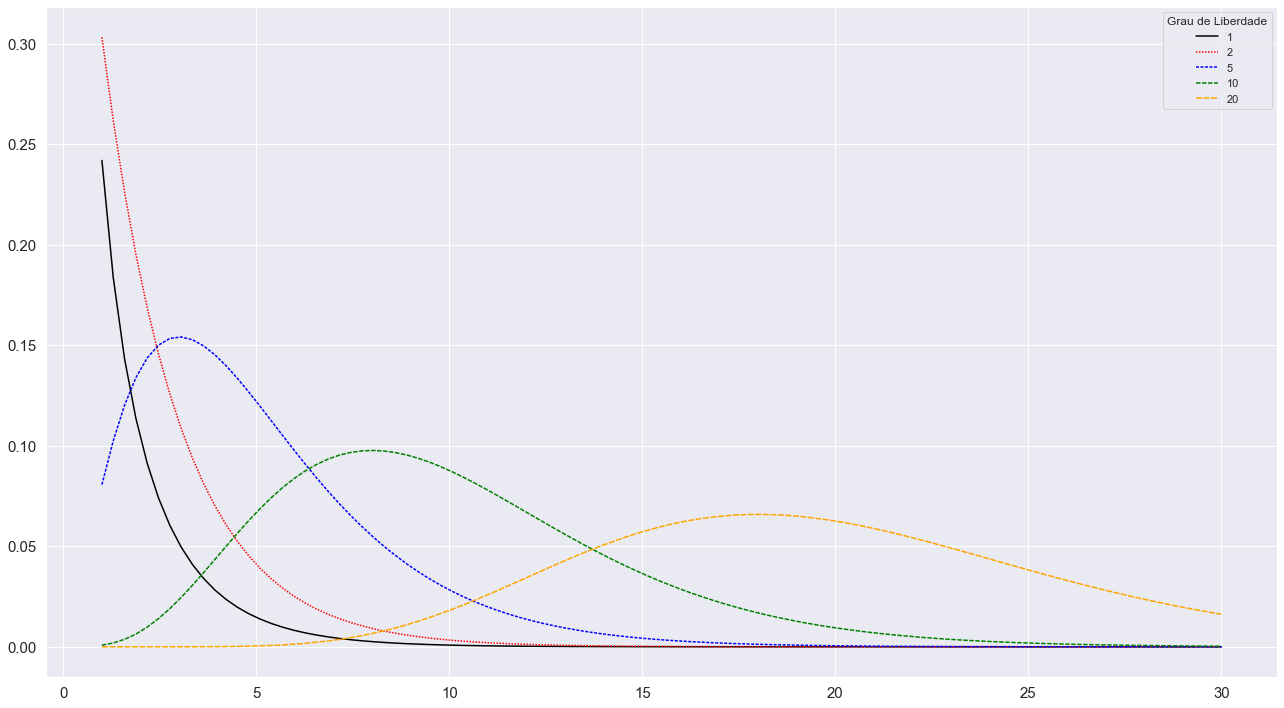

In [60]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1':  stats.chi2.pdf(x, df=1),
    'chi_2':  stats.chi2.pdf(x, df=2),
    'chi_5':  stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20), })

fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(chi.x, chi.chi_1,  color='black',  linestyle='-'        , label='1' )
ax.plot(chi.x, chi.chi_2,  color='red',    linestyle=(0, (1, 1)), label='2' )
ax.plot(chi.x, chi.chi_5,  color='blue',   linestyle=(0, (2, 1)), label='5' )
ax.plot(chi.x, chi.chi_10, color='green',  linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='orange', linestyle=(0, (4, 1)), label='20')
ax.legend(title='Grau de Liberdade')

plt.tight_layout()
plt.show()

## 3.12 Teste Exato de Fisher

A distribuição qui quadrada é uma boa aproximação do teste de reamostragem embaralhada descrito anteriormente, exceto quando as contagens são extremamente baixas. 
* dígitos únicos, especialmente cinco ou menos
* Nesses casos, o procedimento de reamostra resultará em valores p mais precisos.

Na verdade, a maioria dos softwares estatísticos tem um procedimento para realmente enumerar todas as possíveis reorganizações (permutações) que podem ocorrer, tabular suas frequências e **determinar exatamente quão extremo é o resultado observado.**

Isso se chama teste exato de Fisher, em homenagem ao grande estatístico R. A. Fisher. 

O valor p é muito próximo ao valor p de 0.4853 obtido usando o método de reamostragem. 

Onde algumas contagens são muito baixas, mas outras são bem altas
* por exemplo, o denominador em uma taxa de conversão, pode ser necessário fazer um teste de permutação embaralhada, em vez de um teste exato completo, devido à dificuldade de calcular todas as possíveis permutações.

In [61]:
# stats.fisher_exact(clicks.values)

Scipy has only an implementation of Fisher's Exact test for 2x2 matrices. 

There is a github repository that provides a Python implementation that uses the same code as the R version. 

Installing this requires a Fortran compiler. 

### Detectando Fraude Científica

Um exemplo interessante é o da pesquisadora da Tufts University, Thereza Imanishi- Kari, que foi acusada em 1991 de fabricar os dados em sua pesquisa.

O congressista John Dingell se envolveu, e o caso acabou levando à demissão de seu colega, David Baltimore, da presidência da Rockefeller University.

Imanishi-Kari foi finalmente exonerada após um longo processo.

**No entanto, um elemento no caso se baseou em evidências estatísticas a respeito da distribuição esperada dos dígitos nos dados de seu laboratório, onde cada observação tinha muitos dígitos.**

Os investigadores se concentraram nos dígitos internos, que se esperava que seguissem uma distribuição aleatória uniforme.

Ou seja, ocorreriam aleatoriamente, com cada dígito tendo igual probabilidade de ocorrer
* O dígito principal poderia ser predominantemente um valor
* Os dígitos finais poderiam ser afetados pelo arredondamento

A Tabela 3-7 lista as frequências dos dígitos interiores dos dados reais do caso.

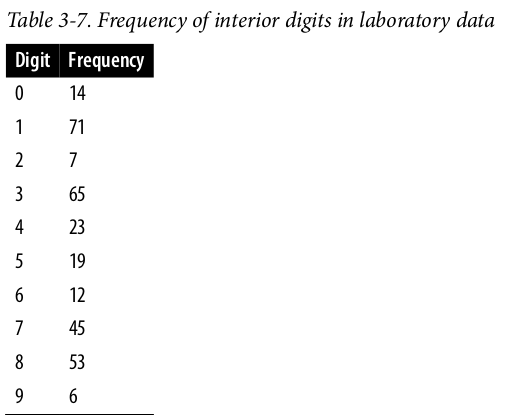

In [62]:
Image('/home/deivison/Documentos/projetos/stats/imagem/cap_03_chi_5.png')

A distribuição dos 315 dígitos, mostrada na Figura 3-8, certamente não parece aleatória:
* Os investigadores calcularam a partida da expectativa
* 31.5 — essa é a frequência com que cada dado ocorreria em uma distribuição estritamente uniforme e usaram um teste de qui quadrado para mostrar que a distribuição real estava muito além da taxa de variação normal do acaso
* um procedimento de reamostragem poderia ter sido usado da mesma forma

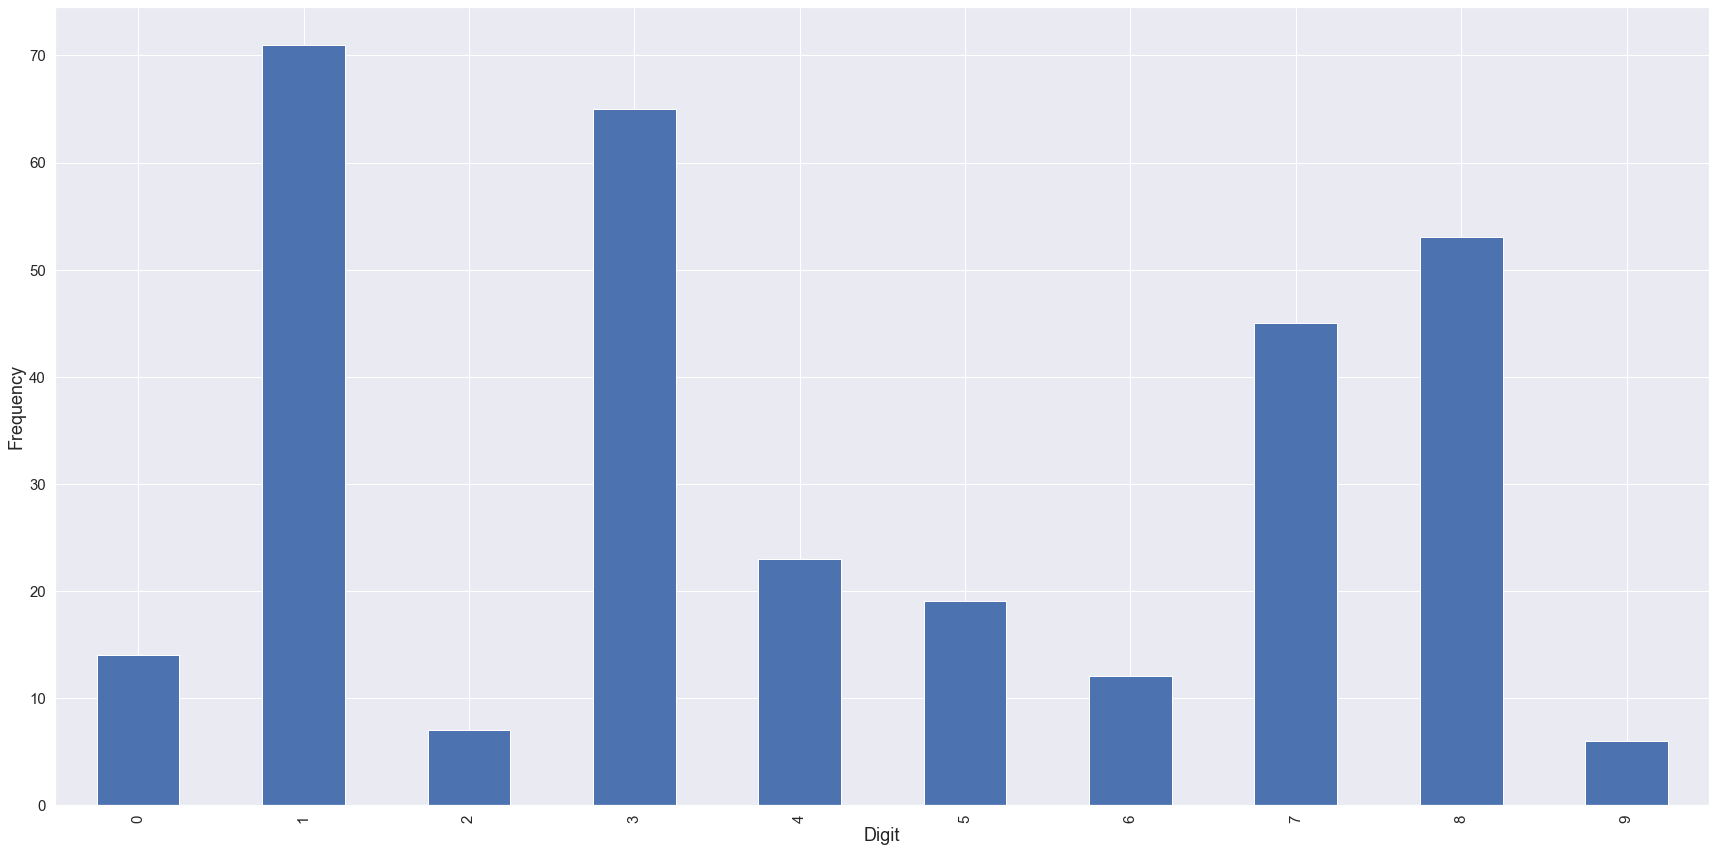

In [63]:
imanishi = pd.read_csv(IMANISHI_CSV)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                      figsize=(24, 12))
ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Relevância para Ciência de Dados

<font color=red>**A maioria dos usos do teste de qui quadrado, ou teste exato de Fisher, não é muito relevante para a ciência de dados.**</font>

* **Na maioria dos experimentos, seja A-B ou A-B-C… :**
    * o objetivo não é simplesmente estabelecer a significância estatística
    * mas, sim, chegar ao melhor tratamento.
    * Para tanto, os bandidos multibraços oferecem uma solução mais completa.

Uma **aplicação em ciência de dados** para o teste de qui quadrado, especialmente a versão exata de Fisher, é na **determinação de tamanhos de amostra adequados para experimentos web.**
* Esses experimentos costumam ter taxas de cliques muito baixas
* Apesar de milhares de exposições
    * A taxas de contagem podem ser muito pequenas para gerar conclusões definitivas em um experimento.
* <font color=blue>**Nesses casos, o teste exato de Fisher, o teste de qui quadrado e outros testes podem ser úteis como componentes de cálculos de potência e tamanho de amostra.**</font>

Os testes de qui quadrado são muito usados em pesquisa por investigadores em busca do elusivo e estatisticamente significativo valor p que permitirá a publicação.

<font color=red>**Os testes de qui quadrado, ou simulações de reamostragem semelhantes, são usados em aplicações de ciências de dados mais como um filtro para determinar se um efeito ou característica é digno de maiores considerações do que um teste formal de significância.**</font> 

Por exemplo, são usados em estatísticas e mapeamentos espaciais para determinar se os dados espaciais obedecem a uma distribuição nula específica.
* Por exemplo, os crimes estão concentrados em uma certa área em maior grau do que o acaso permitiria? 
* Podem ser usados também na seleção automatizada de características em aprendizado de máquina:
    * Para avaliar a prevalência de classes entre características
    * Para identificar características nas quais a prevalência de uma certa classe é excepcionalmente alta ou baixa, de uma forma incompatível com a variação aleatória.

## 3.13 Potência e Tamanho de Amostra

### Termos Chave

**Tamanho do efeito**
* O tamanho mínimo do efeito que se espera poder detectar em um teste estatístico
* Por exemplo, “uma melhora de 20% em taxas de clique”.

**Potência**
* A probabilidade de detectar um dado tamanho de efeito com dado tamanho de amostra.

**Nível de significância**
* O nível de significância estatística no qual o teste será conduzido.

### Teoria

<font color = blue>**Se você executar um teste web, como decidirá por quanto tempo deve executar?**</font>
* Ou seja, quantas impressões por tratamento são necessárias?

Apesar do que se pode ver em muitos guias de testagem web na internet
* Não existe um bom direcionamento geral
* Depende, principalmente, da frequência com a qual o objetivo desejado é atingido.

**Um dos passos nos cálculos estatísticos para tamanho de amostra é perguntar:**
* “Um teste de hipótese revelará realmente uma diferença entre os tratamentos A e B?”
* O resultado de um teste de hipótese — o valor p — depende da real diferença entre os tratamentos A e B.
    * Depende também da sorte na extração
    * Quem é selecionado para os grupos no experimento.
* Mas faz sentido que quanto maior a diferença real entre os tratamentos A e B
    * Maior a probabilidade de que o experimento a revelará.
    * E quanto menor a diferença, mais dados serão necessários para detectá-la.

**Exemplo REBATEDOR**

Para distinguir entre um rebatedor .350 no basebol e um rebatedor .200
* Não são necessárias muitas rebatidas.

Para distinguir entre um rebatedor .300 e um rebatedor .280
* serão necessárias muitas rebatidas a mais.

<font color = red>**A potência é a probabilidade de detectar um tamanho de efeito especificado com características de amostra especificadas.**</font>
* Tamanho e variabilidade

Por exemplo, podemos dizer (hipoteticamente) que a probabilidade de distinguir entre um rebatedor .330 e um rebatedor .200 em 25 rebatidas é de .75.

* **O tamanho do efeito aqui é a diferença de .130**
* E “detectar” significa que um teste de hipótese rejeitará a hipótese nula de “sem diferença”
* Concluirá que existe um efeito real.
* Então o experimento de 25 rebatidas (n = 25) para 2 rebatedores, com um tamanho de efeito de 0.130, tem (hipoteticamente) potência de 0.75 ou 75%.

Pode-se ver que aqui existem diversas partes móveis, e é fácil se enrolar nas muitas suposições e fórmulas estatísticas que serão necessárias para especificar:
* Variabilidade de amostra
* Tamanho do efeito
* Tamanho da amostra
* Nível alfa para o teste de hipótese etc.
* Calcular a potência.

De fato, existe um software estatístico especialmente para calcular a potência.

<font color = red>**Muitos cientistas de dados não precisarão passar por todos os processos formais necessários para registrar a potência, por exemplo, em um artigo publicado.**</font>

<font color = blue>**No entanto, podem se ver em situações em que queiram coletar alguns dados para um teste A/B, e a coleta ou o processamento dos dados envolve algum custo.**</font>

* Nesse caso, saber aproximadamente quantos dados coletar pode ajudar a evitar uma situação em que se faz um certo esforço para coletar os dados, e o resultado acaba sendo inconclusivo.

**Aqui está uma abordagem alternativa bastante intuitiva:**
1. Comece com alguns dados hipotéticos que representem seu melhor palpite sobre os dados resultantes
    * talvez com base em dados anteriores
    * Por exemplo, uma caixa com 20 uns e 80 zeros para representar um rebatedor .200, ou uma caixa com algumas observações do “tempo gasto no site”.
    
    
2. Crie uma segunda amostra simplesmente somando o tamanho desejado de efeito à primeira amostra
    * Por exemplo, uma segunda caixa com 33 uns e 67 zeros
    * Ou uma segunda caixa com 25 segundos adicionados a cada “tempo gasto no site” inicial.
    
    
3. Extraia uma amostra bootstrap de tamanho n de cada caixa.


4. Conduza um teste de hipótese de permutação (ou baseado em fórmula) nas duas amostras bootstrap e registre se a diferença entre elas é estatisticamente significativa.


5. Repita os dois passos anteriores muitas vezes e defina a frequência com que a diferença foi significativa — esta é a potência estimada.

### Tamanho da Amostra

#### Teoria

<font color = red>**O uso mais comum dos cálculos de potência é estimar quão grande será a amostra necessária.**</font>

Por exemplo, suponha que estejamos **observando taxas de clique** (cliques como percentual de exposição) e testando um novo anúncio contra um anúncio existente.
* **É necessário acumular quantos cliques no estudo?**

Se estivermos interessados apenas em resultados que mostrem uma enorme diferença
* Digamos, uma diferença de 50%
* Uma amostra relativamente pequena poderia ser útil.

Se, por outro lado, mesmo a menor diferença seria interessante
* Então é necessário ter uma amostra muito maior.

**Uma abordagem-padrão é estabelecer uma política de que um novo anúncio tem que ser melhor que o existente em certo percentual**
* Digamos 10%, ou então o anúncio existente continuará ativo.
* Este objetivo, o “tamanho do efeito”, define o tamanho da amostra.

<font color = blue>**Por exemplo, suponhamos que as taxas de clique atuais sejam de cerca de 1,1%, e estamos buscando um aumento de 10% (0.11) para 1,21% ( 1.1 + 0.11 ).**</font>
* Então, temos duas caixas:

    * Caixa A com 1,1%  de uns (digamos, 110 uns e 9.890 zeros)
    * Caixa B com 1,21% de uns (digamos, 121 uns e 9.879 zeros).

Para começar, façamos **300 extrações** de cada caixa (isso seria como 300 “impressões” para cada anúncio). 

Suponhamos que nossa primeira extração resulte o seguinte:
* Caixa A 3 ones
* Caixa B 5 ones

De início podemos ver que qualquer teste de hipótese que revelasse essa diferença (cinco comparações) estaria dentro da taxa de variação do acaso.

<font color = blue>**Essa combinação de tamanho de amostra (n = 300 em cada grupo) e tamanho de efeito (diferença de 10%) é muito pequena para qualquer teste de hipótese mostrar uma diferença confiável.**</font>

**Tamanho da amostra necessário para detectar o efeito = 116602.393**

In [64]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)

analysis = sm.stats.TTestIndPower()

result = analysis.solve_power(effect_size = effect_size, 
                              alpha = 0.05,
                              power = 0.8,
                              alternative = 'larger')

print('Sample Size: %.3f' % result)

Sample Size: 116602.393


**Então podemos tentar aumentar o tamanho da amostra (vamos tentar 2.000 impressões) e exigir uma melhoria maior (30%, em vez de 10%).**

<font color = green>**Por exemplo, suponhamos que as taxas de clique atuais ainda sejam de 1,1%, mas agora buscamos um aumento de 50% (0.55) para 1,65% ( 1.1 + 0.55 ).**</font>

* Então temos duas caixas: 
    * Caixa A com 1,1%  de uns (digamos 110 uns e 9.890 zeros)
    * Caixa B com 1,65% de uns (digamos 165 uns e 9.868 zeros).

Agora vamos tentar **2.000 extrações** de cada caixa.

Suponha que nossa primeira extração resulte o seguinte:
* Caixa A 19 ones
* Caixa B 34 ones

Um teste de significância nessa diferença (34–19) mostra
* Um registro como “não significante”
* Apesar de estar muito mais próximo da significância do que a diferença anterior de 5–3.

**Para calcular a potência:**
* Precisaríamos repetir o procedimento anterior muitas vezes
* Ou usar um software de estatística que possa calcular a potência.

<font color = blue>**Mas nossa extração inicial sugere que mesmo a detecção de uma melhoria de 50% ainda exige diversos milhares de impressões de anúncio.**</font>

**Tamanho da amostra necessário para detectar o efeito = 5488.408**

In [65]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)

analysis = sm.stats.TTestIndPower()

result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05,
                              power=0.8,
                              alternative='larger')

print('Sample Size: %.3f' % result)

Sample Size: 5488.408


<font color = red>**Resumindo, para calcular a potência ou o tamanho de amostra necessário, existem quatro partes móveis:**</font>
1. Tamanho da amostra
2. Tamanho do efeito que queremos detectar
3. Nível de significância (alfa) em que o teste será conduzido
4. Potência.

* Especifique quaisquer três dentre eles, e o quarto poderá ser calculado.
* **Mais comumente, seria preferível calcular o tamanho da amostra**
* Então é necessário especificar os outros três. 

### Ideias Chave

* Descobrir qual é o tamanho de amostra necessário exige a consideração antecipada ao teste estatístico que planeja conduzir.


* É necessário especificar o tamanho mínimo do efeito que se quer detectar.


* Deve-se também especificar a probabilidade exigida de se detectar tal tamanho de efeito (potência).


* Finalmente, é necessário especificar o nível de significância (alfa) em que o teste será conduzido.

## 3.14 Resumo do Capítulo

Os princípios do projeto experimental
* Randomização de indivíduos em dois ou mais grupos recebendo tratamentos diferentes
* Nos permite tirar conclusões válidas sobre quão bem os tratamentos funcionam.

<font color = red>**É melhor incluir um tratamento de controle de “não fazer diferença”.**</font>

**O assunto da inferência estatística formal**
* Testagem de hipótese
* Valores p
* Testes t e muitos mais

**Ocupa muito tempo e espaço em um curso ou livro tradicional de estatística**
* A formalidade é bastante desnecessária na perspectiva da ciência de dados.
* No entanto, continua importante para reconhecer o papel que a variação aleatória pode ter em enganar o cérebro humano.

<font color = red>**Os procedimentos de reamostragem intuitiva (permutação e bootstrap) permitem que os cientistas de dados avaliem o quanto a variação do acaso pode influenciar suas análises de dados.**</font>